In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Davy SIMEU & Sacha CLAVEL

In [2]:
%cd drive/MyDrive/Colab\ Notebooks/ia304 
%ls

/content/drive/MyDrive/Colab Notebooks/ia304
binaryalphadigs.mat


# Import des librairies

In [3]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# Récupération des données

## Utilitaires / Routines

In [4]:
def char_to_index(char):
  ascii = ord(char)
  if 48<=ascii<=57: # 0, 1, ..., 9
    return ascii-48
  elif 65<=ascii<=90: # A, B, ..., Z
    return ascii-65+10
  elif 97<=ascii<=122: # a, b, ..., z
    return ascii-97 + 10
  else:
    print('Error: {} is not a digit or a letter'.format(char))
    return -1

def index_to_char(index):
  if 0<=index<=9: # Digits
    return str(index)
  elif 10<=index<=35: # Letters
    return str(chr(index-10+65))

def plot_random_sample_of_each_char(X, n_sample_per_char=39, 
                                    height=20, width=16, ncol=3):
  n, _ = X.shape
  if n%n_sample_per_char != 0:
    print('Warning: first dimension of X should be ' \
          + 'a multiple of n_sample_per_char={}'.format(n_sample_per_char))
    
  n_char = n//n_sample_per_char
  nrow = n_char//ncol + int(n_char%ncol>0)
  fig, axs = plt.subplots(nrow, ncol)
  for i in range(nrow*ncol):
    if nrow==1:
      ax = axs[i%ncol]
    else :
      ax = axs[i//ncol,i%ncol]

    if i<n_char:
      rand_ind = np.random.randint(i*n_sample_per_char, (i+1)*n_sample_per_char)
      rand_char = X[rand_ind]
      img = rand_char.reshape(height, width)
      ax.matshow(img)
      ax.axis('off')
    else:
      fig.delaxes(ax)

  fig.show()

Dans cette partie, on implémente la fonction ``lire_alpha_digit`` permettant de récupérer les données souhaitées au bon format.

In [5]:
def lire_alpha_digit(file_name, characters, 
                     n_sample_per_char=39, height=20, width=16):
  f = scipy.io.loadmat('binaryalphadigs.mat')
  data = f['dat']

  char_indices = [char_to_index(char) for char in characters if char_to_index(char)!=-1]
  char_indices = np.unique(char_indices)

  N_char = len(char_indices)
  n = n_sample_per_char*N_char
  p = height*width 

  X = np.zeros((n,p))
  for i, idx in enumerate(char_indices):
    for j in range(n_sample_per_char):
      k = i*n_sample_per_char + j
      line = data[idx, j].flatten()
      X[k] = line

  return X

## Exemple de chargement de données

shape of X: (234, 320)


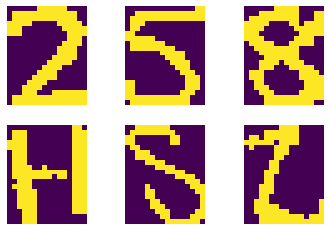

In [6]:
X = lire_alpha_digit('binaryalphadigs.mat', '258SHZ')
print('shape of X: {}'.format(X.shape))
plot_random_sample_of_each_char(X)

# Création de la classe RBM

In [40]:
class RBM():
  def __init__(self, p, q, var=1e-2):
    self.a = np.zeros(p)
    self.b = np.zeros(q)
    self.W = np.random.normal(0, 1, size=(p,q))*np.sqrt(var)
    self.q = q
  
  def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))

  def entree_sortie(self, X):
    return self.sigmoid(X @ self.W + self.b)

  def sortie_entree(self, H):
    return self.sigmoid(H @ self.W.T + self.a)

  def train(self, X, lr=1e-1, batch_size=13, nb_epoch=10, height=20, width=16, epoch_per_plot=1, verbose=True):
    
    n, p = X.shape
    err_history = []
    for epoch in range(nb_epoch):
      np.random.shuffle(X)  
      if verbose:
        print('\n##### Epoch: {}/{} #####'.format(epoch, nb_epoch))
      for batch in range(0, n, batch_size):
        if verbose:
          print('\r>>> samples {:d}/{:d} [{:.0f}%]'.format(batch+1, n, 
                                                  (batch+1)/n*100), end='')
        X_batch = X[batch:min(batch+batch_size, n)]
        current_bs = X_batch.shape[0]

        # Calcul de v_0, v_1, p(v|h) et p(h|v)
        v_0 = X_batch 
        ph_v_0 = self.entree_sortie(v_0) 
        h_0 = (np.random.random((current_bs, self.q)) < ph_v_0).astype(int) 
        pv_h_0 = self.sortie_entree(h_0) 
        v_1 = (np.random.random((current_bs, p)) < pv_h_0).astype(int) 
        ph_v_1 = self.entree_sortie(v_1) 

        # Calcul du gradient (des dérivées partielles)
        grad_a = np.sum(v_0 - v_1, axis=0) 
        grad_b = np.sum(ph_v_0 - ph_v_1, axis=0) 
        grad_W = v_0.T @ ph_v_0 - v_1.T @ ph_v_1

        # Mise à jour des paramètres
        self.W += lr/current_bs * grad_W
        self.a += lr/current_bs * grad_a
        self.b += lr/current_bs * grad_b

      H = self.entree_sortie(X)
      X_rec = self.sortie_entree(H)

      if epoch % epoch_per_plot == 0 and verbose:
        rand_idx = np.random.randint(n)
        original_img = X[rand_idx].reshape(height, width)
        reconstructed_img = X_rec[rand_idx].reshape(height, width)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3,2))
        ax1.imshow(original_img)
        ax1.set_title("Original")
        ax2.imshow(reconstructed_img)
        ax2.set_title("Reconstructed")
        fig.suptitle("Epoch: {}".format(epoch))
        plt.tight_layout()
        plt.show()

      err = np.mean((X-X_rec)**2)
      err_history.append(err)
      if verbose:
        print('\n>>> MSE: {}'.format(err))
      
    return err_history

  def generate(self, nb_iter, thresh=.5, height=20, width=16, ncol=5, nrow=2):
    p, q = self.W.shape
    nb_images = nrow*ncol

    fig, axs = plt.subplots(nrow, ncol, figsize=(15,8))

    for i in range(nb_images):
      v = (np.random.random(p) < thresh).astype(int)
      for j in range(nb_iter):
        ph_v = self.entree_sortie(v) 
        h = (np.random.random(q) < ph_v).astype(int)
        pv_h = self.sortie_entree(h)
        v = (np.random.random(p) < pv_h).astype(int)

      image = v.reshape(height,width)
      axs[i//ncol, i%ncol].imshow(image)
      axs[i//ncol, i%ncol].axis('off')
    plt.tight_layout()
    plt.show()

# Utilisation du modèle et analyse
Nous pouvons maintenant entrainer le modèle et étudier son comportement


##### Epoch: 0/1000 #####
>>> samples 66/78 [85%]

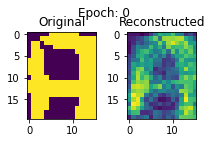


>>> MSE: 0.14337637208467388

##### Epoch: 1/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.12744841076248153

##### Epoch: 2/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.11797865392978195

##### Epoch: 3/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.10641076058499037

##### Epoch: 4/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.10262367923583461

##### Epoch: 5/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.09702844498146693

##### Epoch: 6/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.09057276173690233

##### Epoch: 7/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.08693693894978202

##### Epoch: 8/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.08249017491623899

##### Epoch: 9/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.07813983136427688

##### Epoch: 10/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.07528390197862053

##### Epoch: 11/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0708056431071395

##### Epoch: 12/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.06742706249688889

##### E

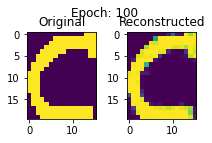


>>> MSE: 0.003521417265223663

##### Epoch: 101/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0033931755855274156

##### Epoch: 102/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.003272685586867403

##### Epoch: 103/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0031704784684161926

##### Epoch: 104/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.003180529881209707

##### Epoch: 105/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.003092334136676683

##### Epoch: 106/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.003158909060793175

##### Epoch: 107/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.002967917495758905

##### Epoch: 108/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00292980904274793

##### Epoch: 109/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0028823597780388214

##### Epoch: 110/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.002847841604902494

##### Epoch: 111/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0027689304902256636

##### Epoch: 112/1000 #####
>>> samples 66/78 [85%]


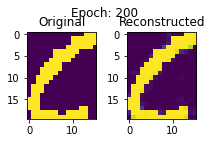


>>> MSE: 0.0006674282842397804

##### Epoch: 201/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0006671531830211187

##### Epoch: 202/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0006878537868594956

##### Epoch: 203/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0006717373235455576

##### Epoch: 204/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0006587160483274612

##### Epoch: 205/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0006319881881359029

##### Epoch: 206/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0006275445759702569

##### Epoch: 207/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0006304672822373231

##### Epoch: 208/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.000621333482199151

##### Epoch: 209/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0006234091666654913

##### Epoch: 210/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.000606107113176614

##### Epoch: 211/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0006162522913616505

##### Epoch: 212/1000 #####
>>> samples 66/78

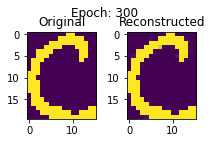


>>> MSE: 0.00026560181452193056

##### Epoch: 301/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0002641628924071598

##### Epoch: 302/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0002583152936708164

##### Epoch: 303/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00025874317761959

##### Epoch: 304/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0002664129665800576

##### Epoch: 305/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00026225921942134935

##### Epoch: 306/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0002734628038600112

##### Epoch: 307/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00026418725718910414

##### Epoch: 308/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0002578489362772822

##### Epoch: 309/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.000251828331136375

##### Epoch: 310/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0002546304066599347

##### Epoch: 311/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00026144934397577226

##### Epoch: 312/1000 #####
>>> samples 66

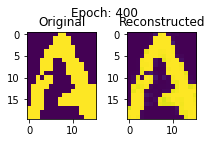


>>> MSE: 0.0001510691448725981

##### Epoch: 401/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00015283050284835848

##### Epoch: 402/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00015560631929606425

##### Epoch: 403/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00015542298896323943

##### Epoch: 404/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0001555862446800823

##### Epoch: 405/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00015221611925252197

##### Epoch: 406/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0001477519807759055

##### Epoch: 407/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00014751888561188674

##### Epoch: 408/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00014781360687059897

##### Epoch: 409/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00014775936390712548

##### Epoch: 410/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00014041947750656513

##### Epoch: 411/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00014108046551186373

##### Epoch: 412/1000 #####
>>> sa

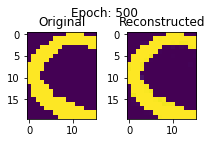


>>> MSE: 9.300858641698744e-05

##### Epoch: 501/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 9.26912249489621e-05

##### Epoch: 502/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 9.243233609733464e-05

##### Epoch: 503/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 9.08157824494131e-05

##### Epoch: 504/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 9.552321703219135e-05

##### Epoch: 505/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 9.758745099490899e-05

##### Epoch: 506/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00010052943717494078

##### Epoch: 507/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 9.828703762220206e-05

##### Epoch: 508/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 9.546604941937774e-05

##### Epoch: 509/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 9.285799846549837e-05

##### Epoch: 510/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 9.319445876502257e-05

##### Epoch: 511/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 9.277949645147483e-05

##### Epoch: 512/1000 #####
>>> samples 66/7

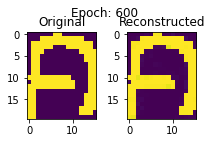


>>> MSE: 6.342359790310458e-05

##### Epoch: 601/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.257786438113837e-05

##### Epoch: 602/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.192356933090047e-05

##### Epoch: 603/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.216718054160718e-05

##### Epoch: 604/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.240826174335898e-05

##### Epoch: 605/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.245418709746917e-05

##### Epoch: 606/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.186774540236595e-05

##### Epoch: 607/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.130016033495858e-05

##### Epoch: 608/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.107371902544424e-05

##### Epoch: 609/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.0317236755500023e-05

##### Epoch: 610/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 5.967472069168948e-05

##### Epoch: 611/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.002368421821428e-05

##### Epoch: 612/1000 #####
>>> samples 66

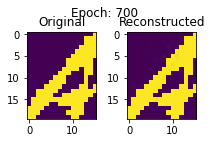


>>> MSE: 4.691840486554329e-05

##### Epoch: 701/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.655859239584882e-05

##### Epoch: 702/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.665366558573585e-05

##### Epoch: 703/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.668336174719238e-05

##### Epoch: 704/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.6998031372460334e-05

##### Epoch: 705/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.62960300559325e-05

##### Epoch: 706/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.526552184166171e-05

##### Epoch: 707/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.507709080700241e-05

##### Epoch: 708/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.4668280068415914e-05

##### Epoch: 709/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.469738312968399e-05

##### Epoch: 710/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.526071878340868e-05

##### Epoch: 711/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.5166487872467103e-05

##### Epoch: 712/1000 #####
>>> samples 6

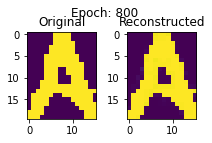


>>> MSE: 3.538258472476098e-05

##### Epoch: 801/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.512481661405234e-05

##### Epoch: 802/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.537601683105054e-05

##### Epoch: 803/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.5075654634666007e-05

##### Epoch: 804/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.511055539171816e-05

##### Epoch: 805/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.4320317249272856e-05

##### Epoch: 806/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.38020763336718e-05

##### Epoch: 807/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.4670445493687525e-05

##### Epoch: 808/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.455228025334084e-05

##### Epoch: 809/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.4967435039376165e-05

##### Epoch: 810/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.493415734164707e-05

##### Epoch: 811/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.4433203392000874e-05

##### Epoch: 812/1000 #####
>>> samples

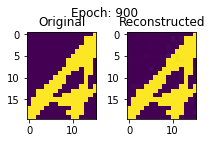


>>> MSE: 2.753452049969352e-05

##### Epoch: 901/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.7411464184852386e-05

##### Epoch: 902/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.7139613089409907e-05

##### Epoch: 903/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.7366849074044372e-05

##### Epoch: 904/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.6785797413320184e-05

##### Epoch: 905/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.6663024305701605e-05

##### Epoch: 906/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.6407696436239654e-05

##### Epoch: 907/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.6847132525122375e-05

##### Epoch: 908/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.6863133449796474e-05

##### Epoch: 909/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.6958919293185173e-05

##### Epoch: 910/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.6300688722968578e-05

##### Epoch: 911/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.619939765729897e-05

##### Epoch: 912/1000 #####
>>> s

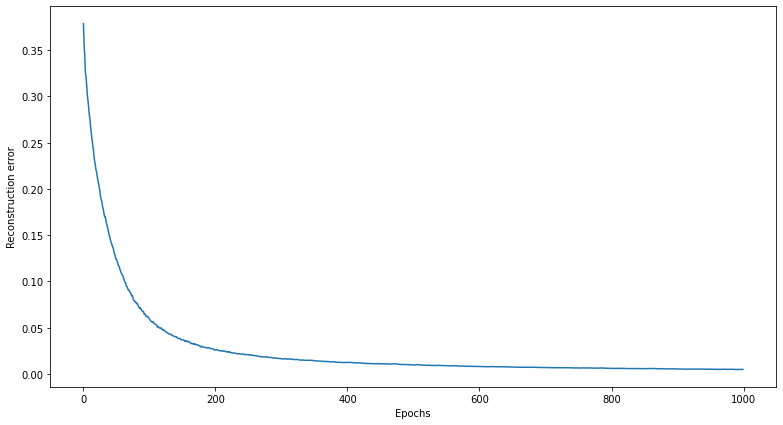

In [41]:
X = lire_alpha_digit('binaryalphadigs.mat', 'AC')
_, p = X.shape

my_rbm = RBM(p, q=256)
err_history = my_rbm.train(X, nb_epoch=1000, lr=1e-1, epoch_per_plot=100)

plt.figure(figsize=(13,7))
plt.plot(np.arange(0, len(err_history)), np.sqrt(err_history))
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

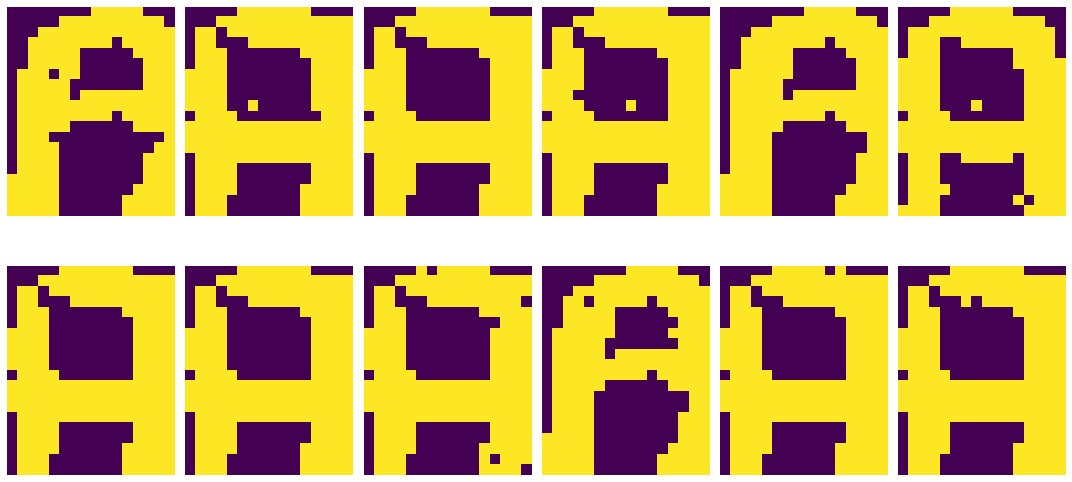

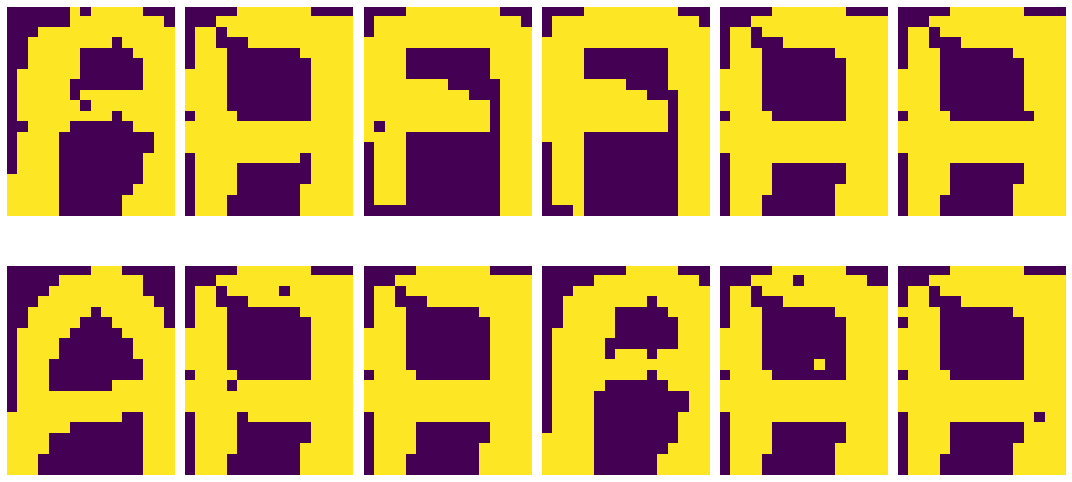

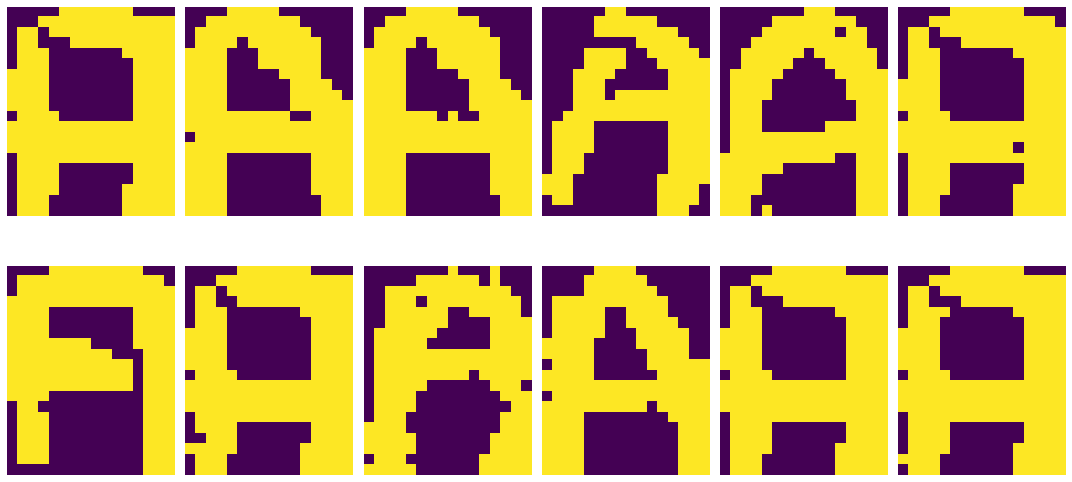

In [42]:
for _ in range(3):
  my_rbm.generate(nb_iter=10, thresh=0.5, ncol=6, nrow=2)

In [38]:
X = lire_alpha_digit('binaryalphadigs.mat', 'A')
_, p = X.shape
lr = 1e-1
lrs = [lr*10, lr, lr/10, lr/100, lr/1000, lr/10000]
err = []
for el in lrs:
  my_rbm = RBM(p, q=256)
  err_history = my_rbm.train(X, nb_epoch=500, lr=el, epoch_per_plot=100, verbose=False)
  err.append(err_history)

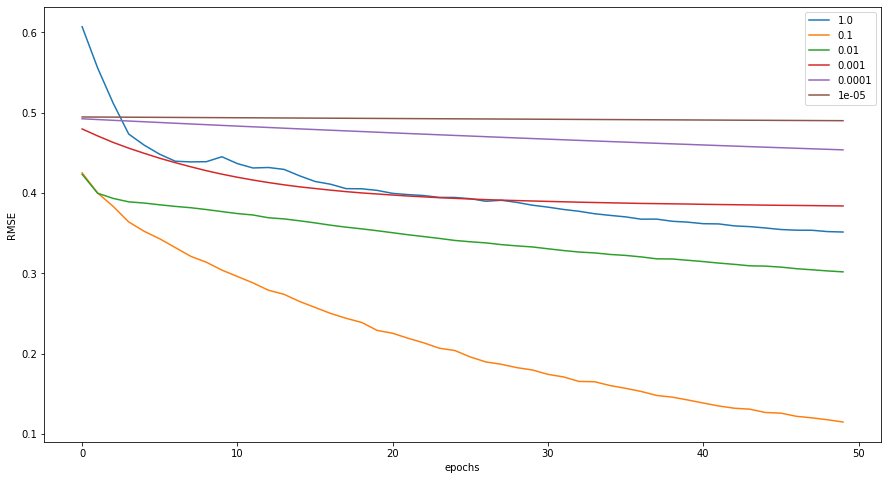

In [40]:
plt.figure(figsize = (15, 8))
for i, el in enumerate(err):
  plt.plot(np.sqrt(el[:50]), label=lrs[i])
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

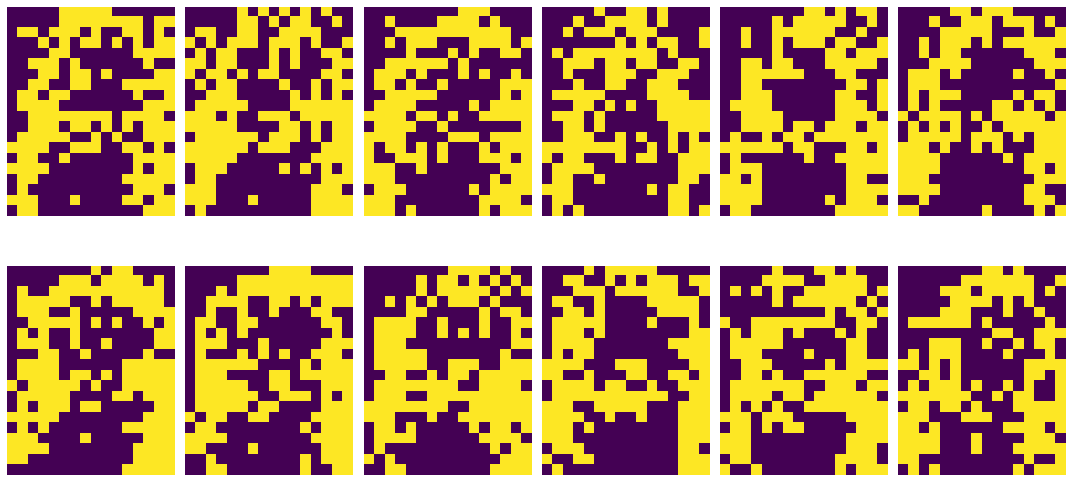

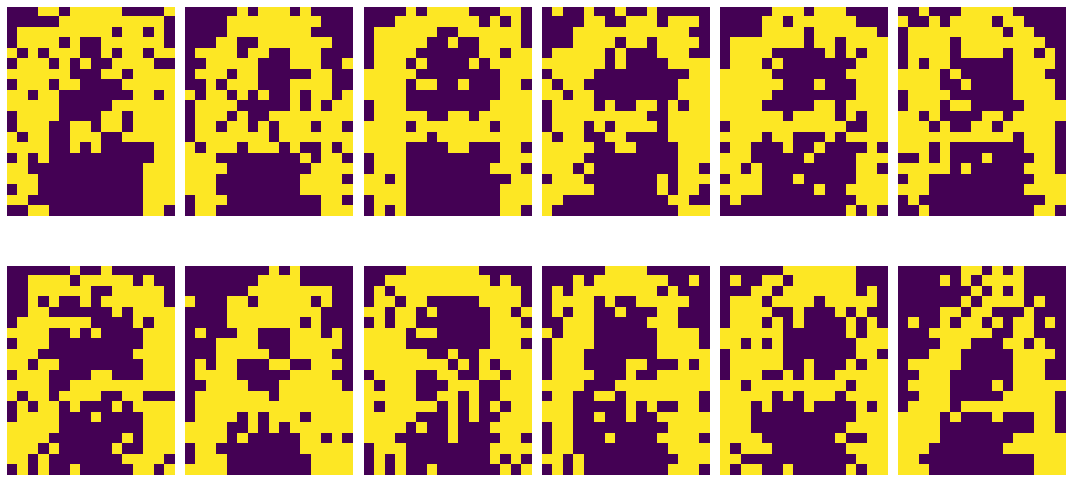

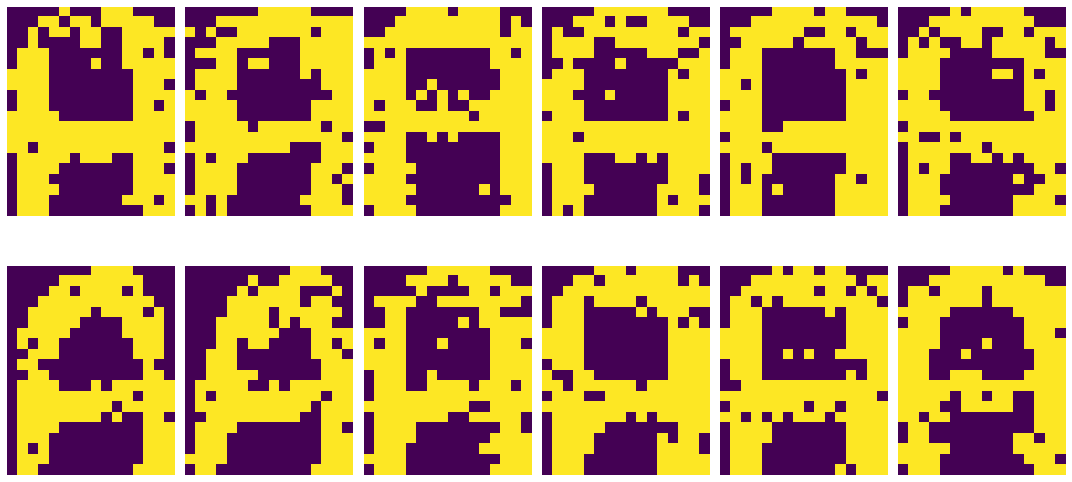

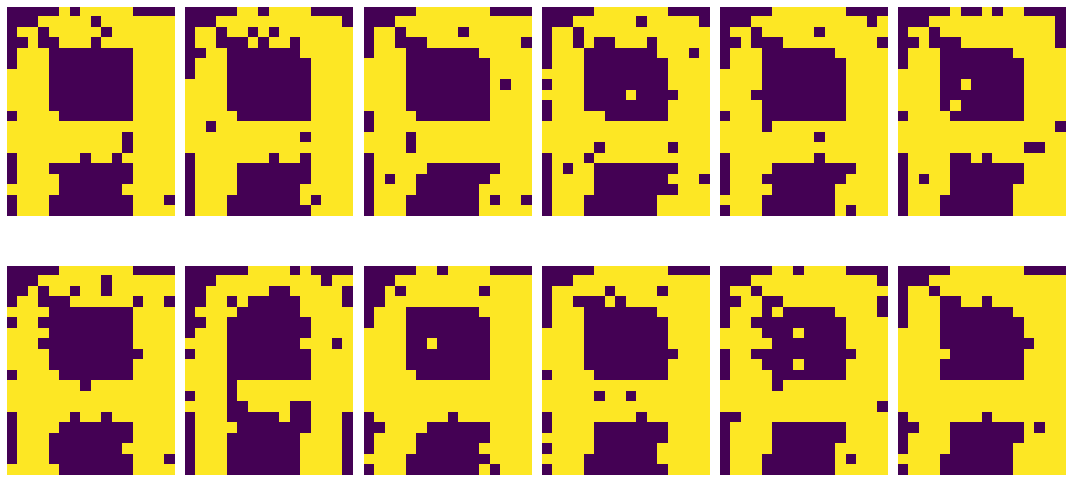

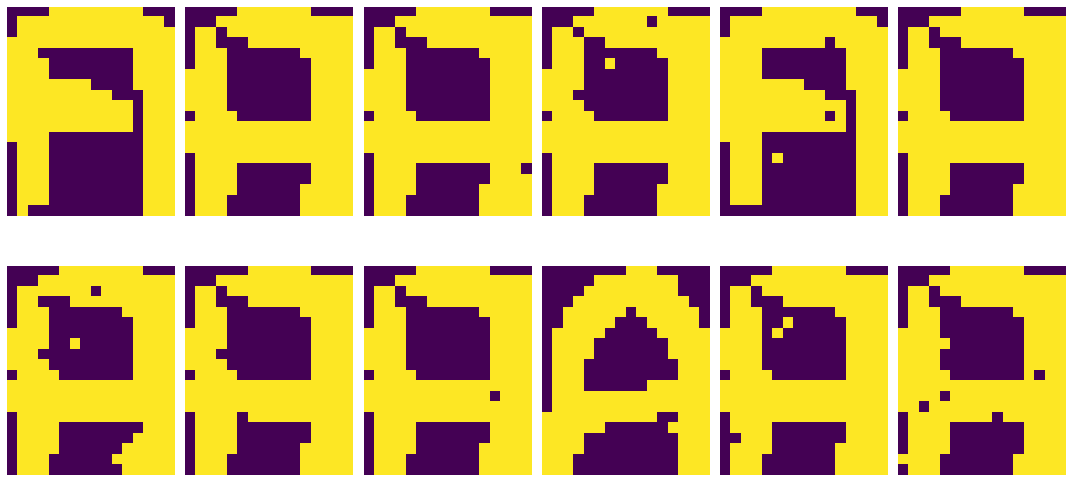

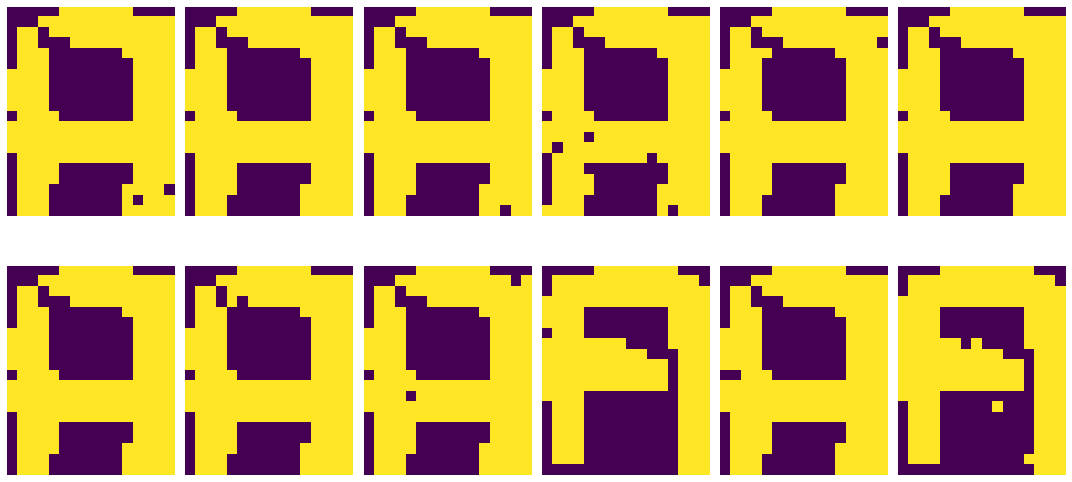

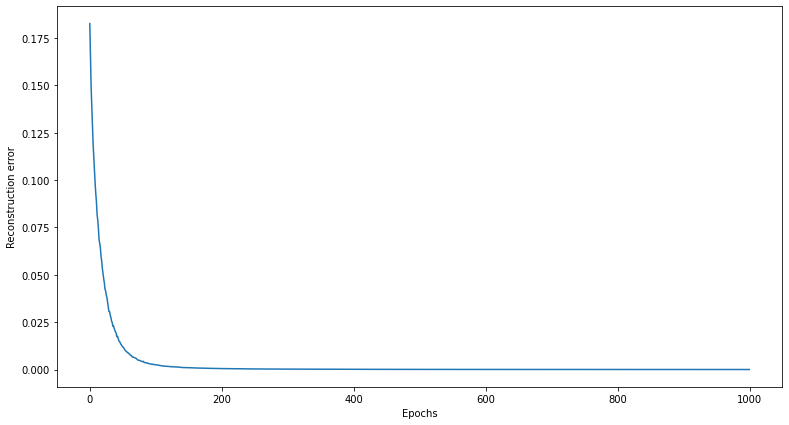

In [44]:
X = lire_alpha_digit('binaryalphadigs.mat', 'A')
_, p = X.shape
lr = 5
epochs = [lr, lr*2, lr*10, lr*20, lr*100, lr*200]
err = []
for el in epochs:
  my_rbm = RBM(p, q=256)
  err_history = my_rbm.train(X, nb_epoch=el, lr=1e-1, epoch_per_plot=100, verbose=False)
  err.append(err_history)
  for _ in range(1):
    my_rbm.generate(nb_iter=10, thresh=0.5, ncol=6, nrow=2)

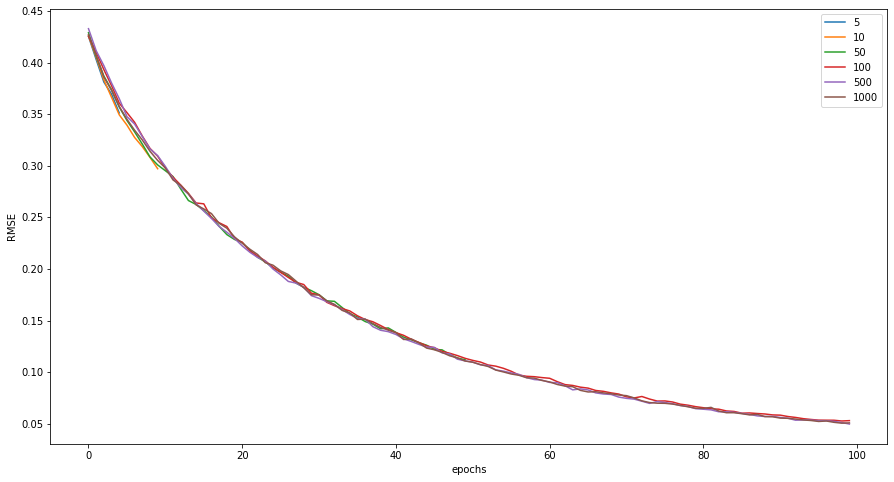

In [45]:
plt.figure(figsize = (15, 8))
for i, el in enumerate(err):
  plt.plot(np.sqrt(el[:100]), label=epochs[i])
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [28]:
X = lire_alpha_digit('binaryalphadigs.mat', 'A')
_, p = X.shape
lr = 32
Qs = [lr, lr*2, lr*4, lr*8, lr*16, lr*32]
err = []
for el in Qs:
  my_rbm = RBM(p, q=el)
  err_history = my_rbm.train(X, nb_epoch=500, lr=1e-1, epoch_per_plot=100, verbose=False)
  err.append(err_history)

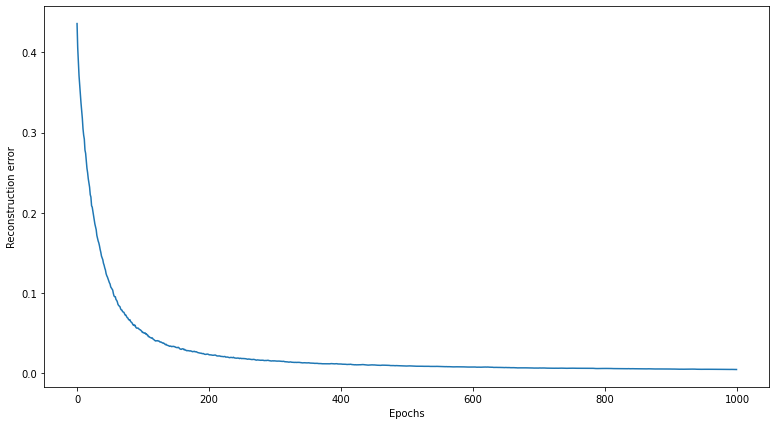

In [27]:
plt.figure(figsize=(13,7))
plt.plot(np.arange(0, len(err_history)), np.sqrt(err_history))
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

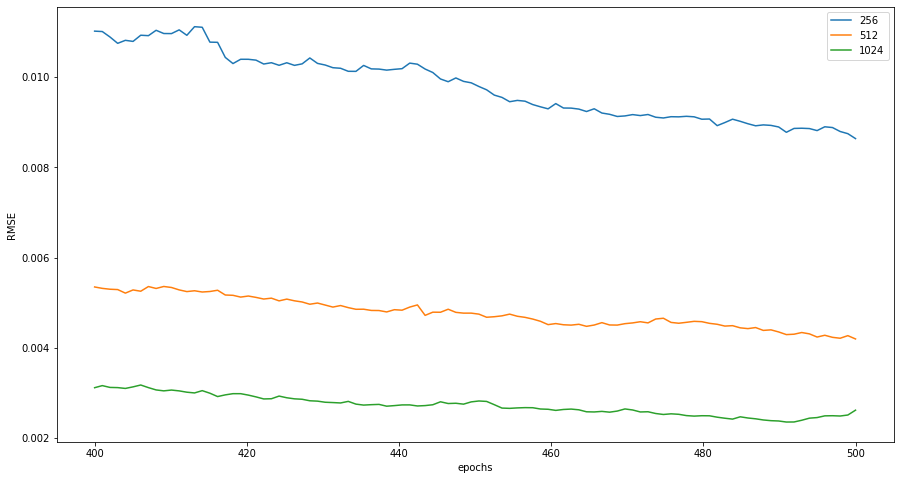

In [37]:
plt.figure(figsize = (15, 8))
for i, el in enumerate(err[-3:]):
  plt.plot(np.linspace(400,500,100),np.sqrt(el[400:]), label=Qs[i-3])
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

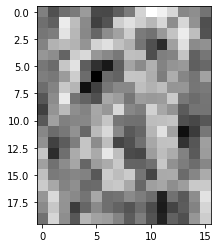

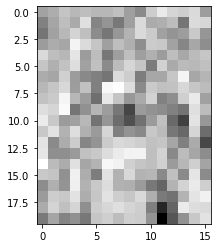

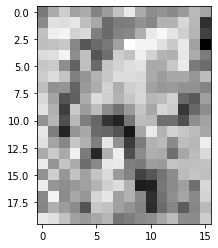

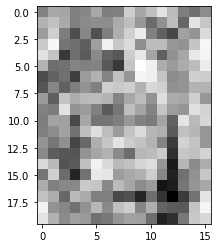

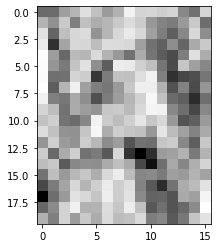

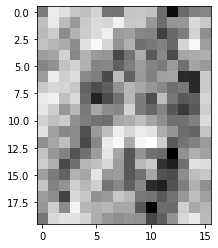

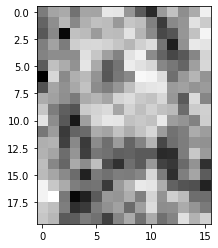

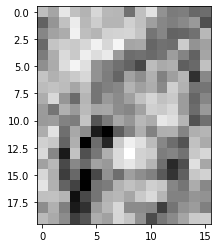

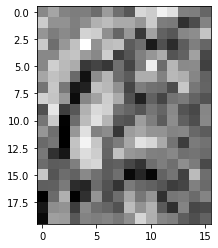

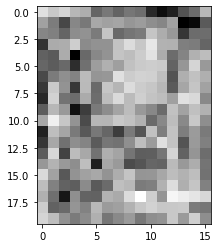

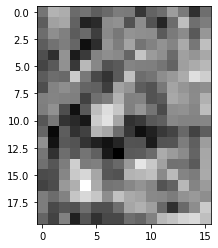

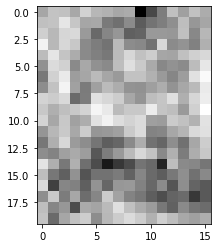

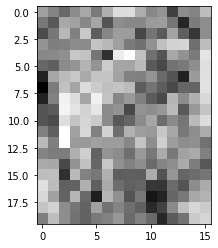

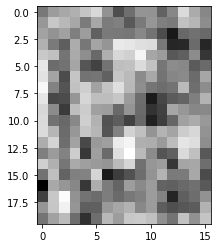

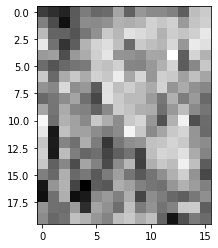

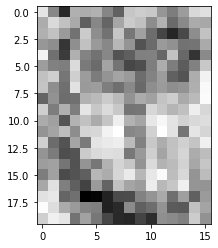

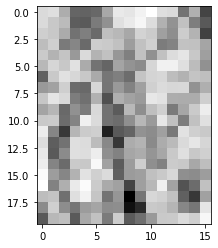

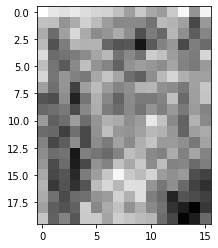

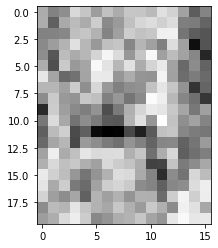

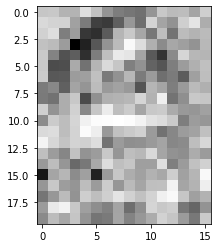

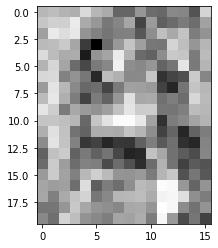

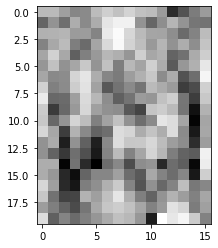

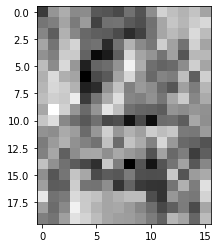

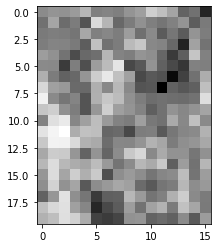

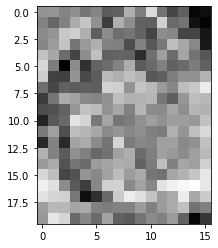

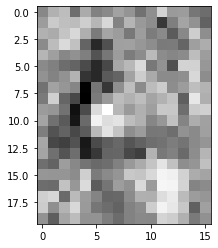

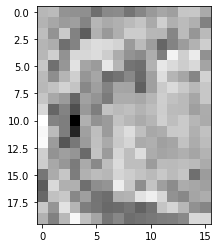

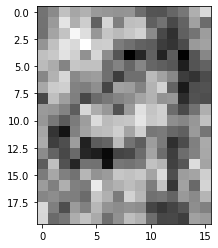

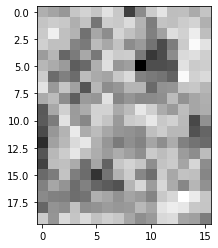

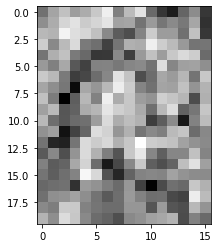

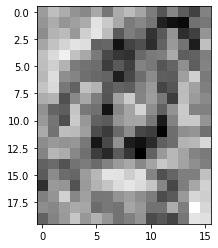

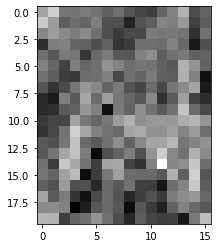

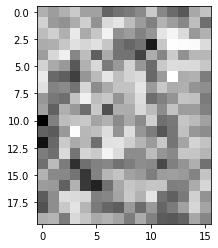

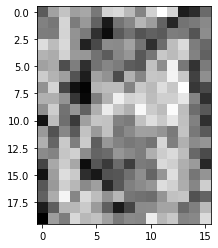

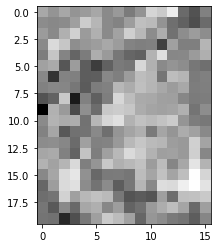

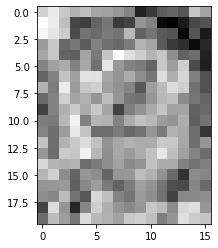

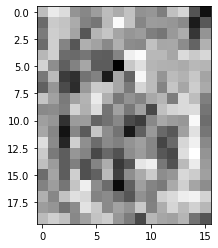

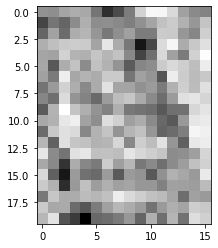

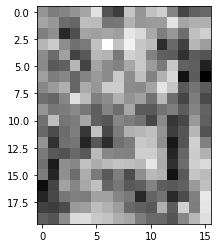

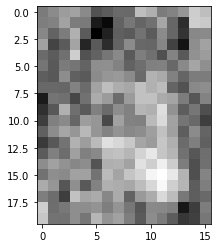

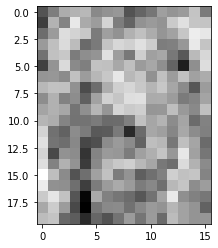

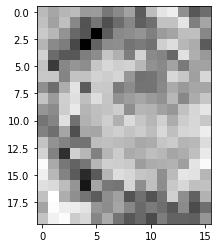

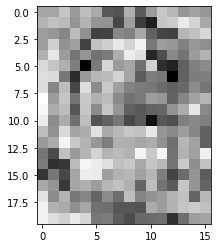

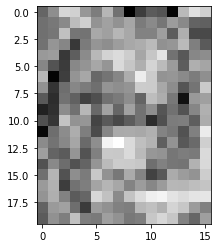

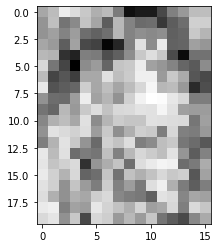

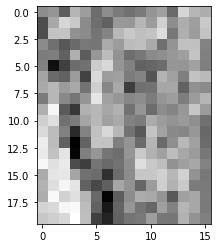

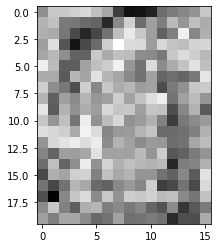

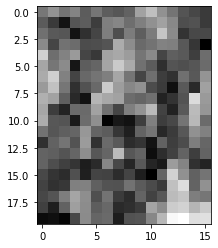

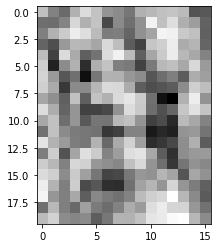

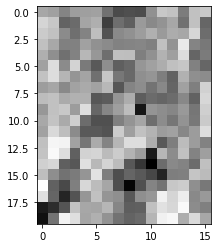

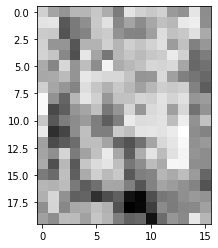

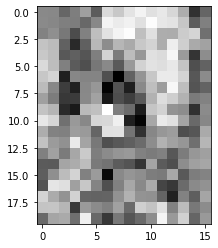

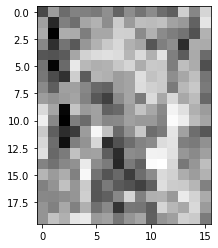

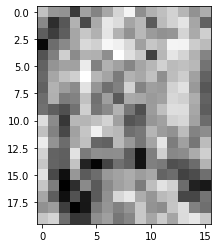

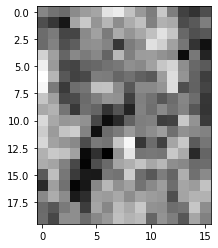

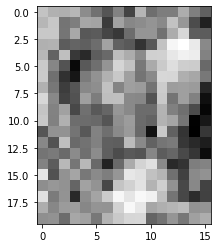

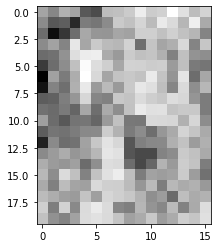

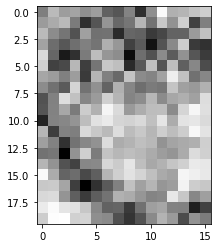

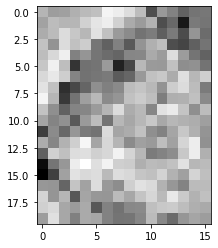

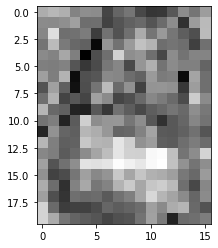

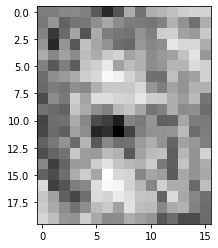

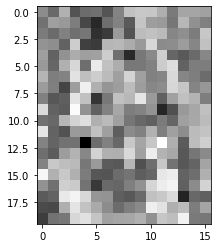

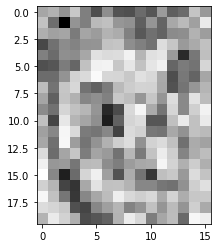

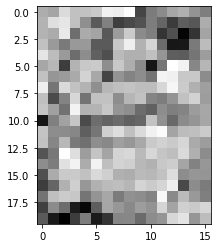

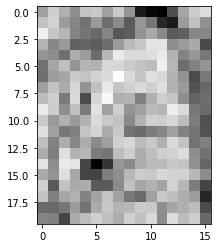

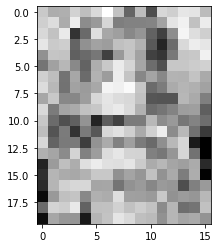

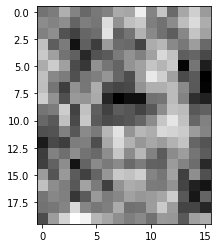

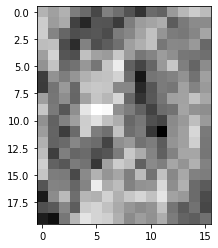

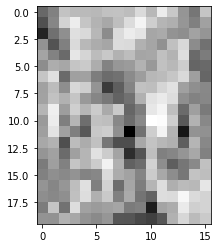

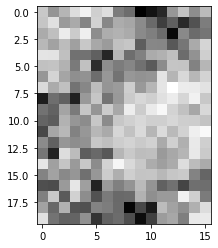

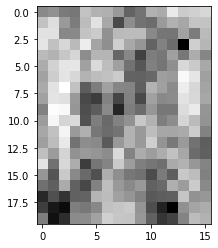

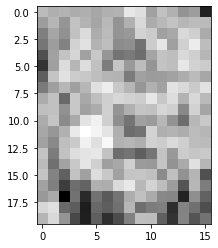

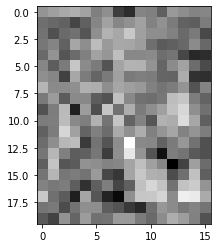

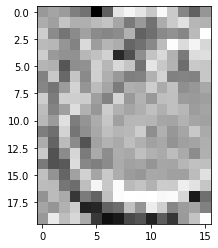

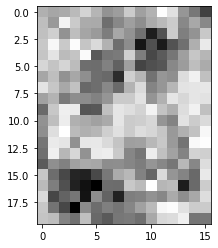

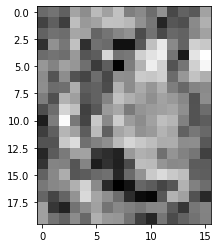

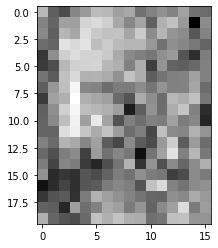

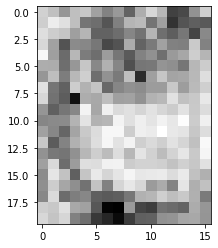

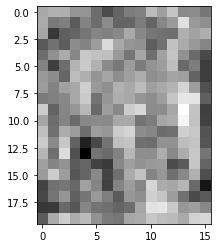

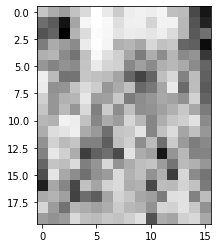

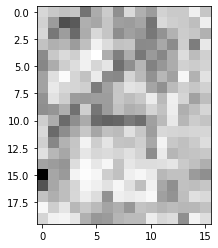

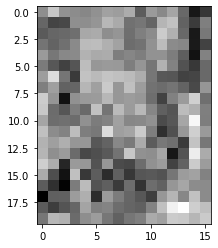

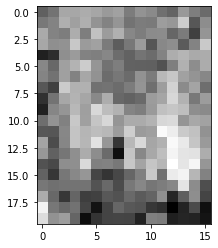

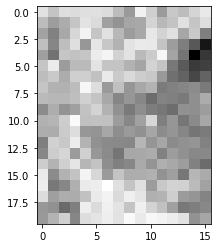

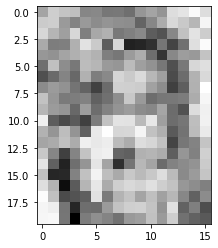

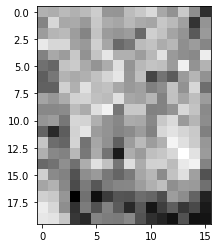

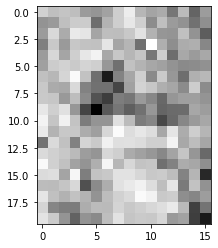

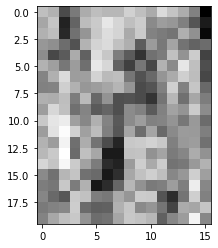

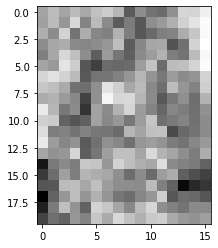

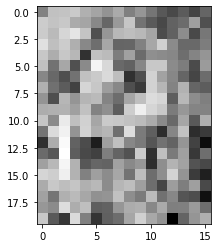

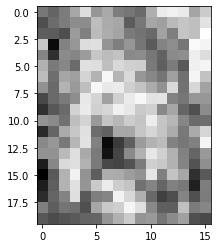

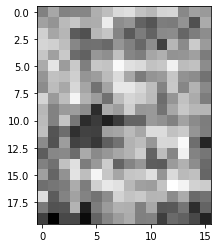

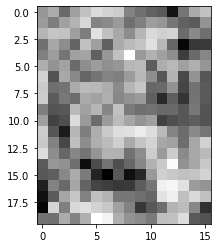

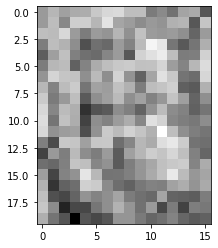

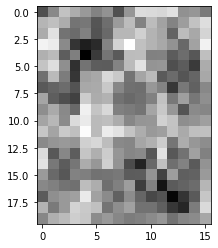

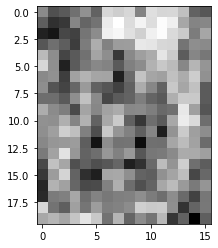

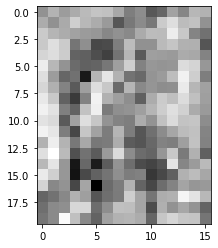

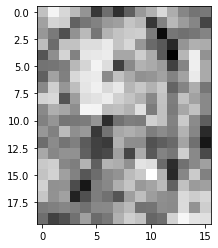

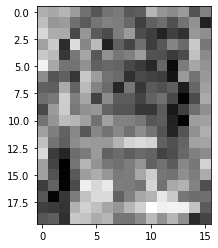

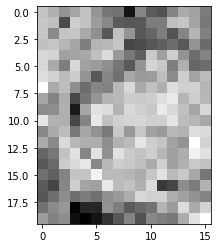

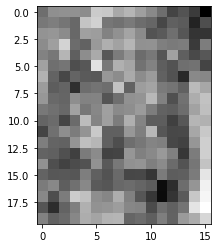

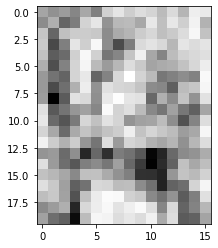

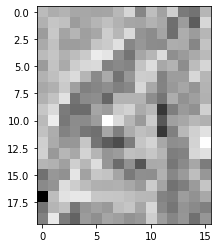

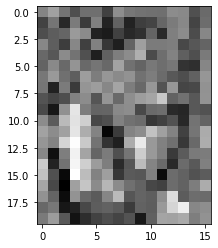

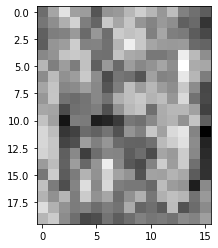

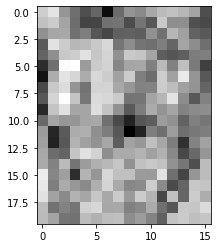

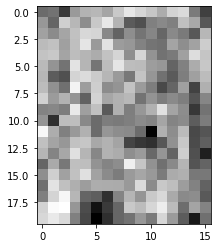

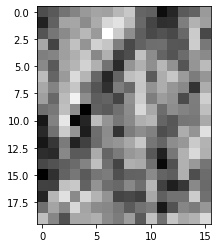

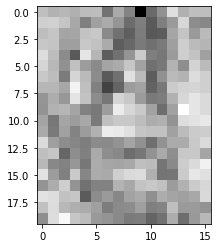

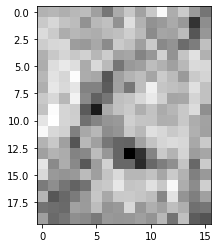

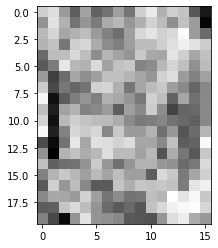

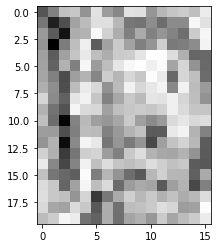

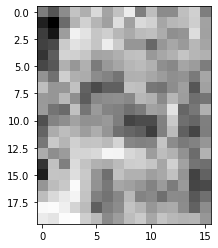

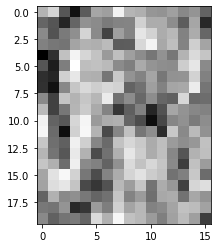

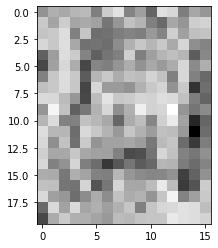

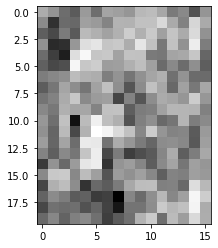

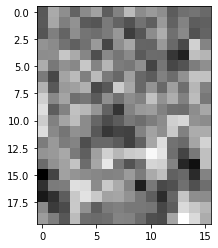

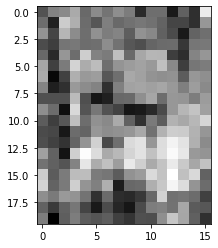

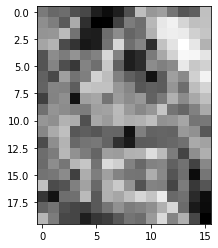

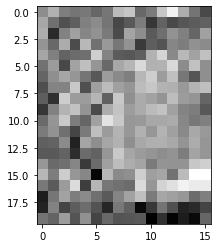

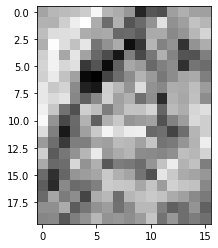

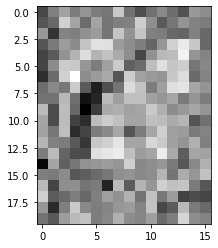

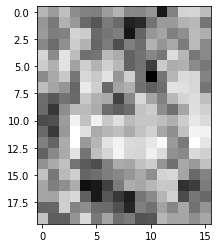

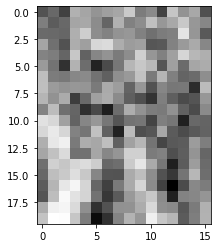

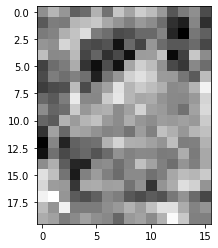

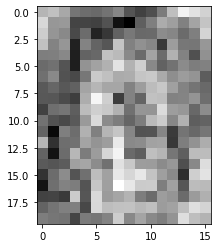

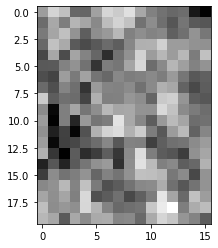

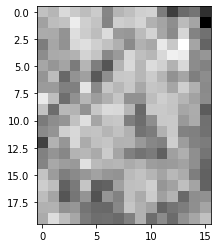

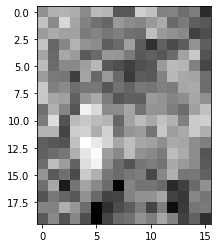

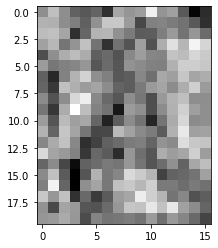

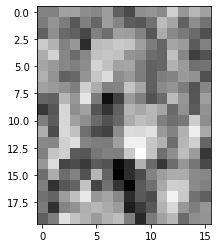

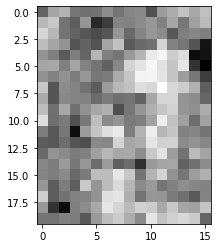

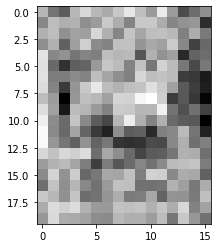

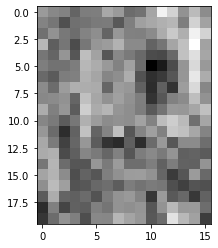

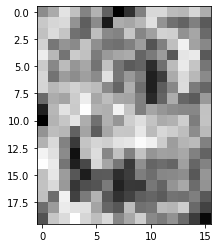

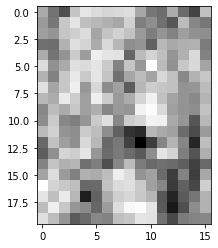

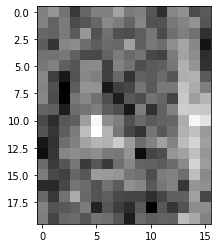

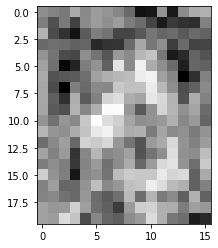

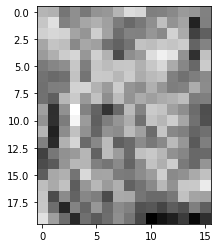

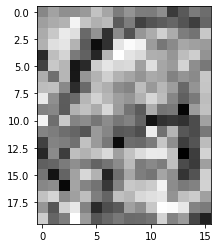

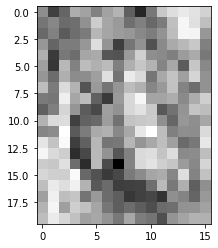

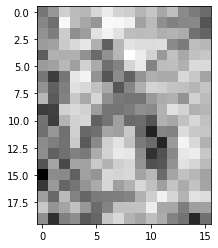

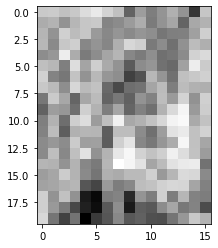

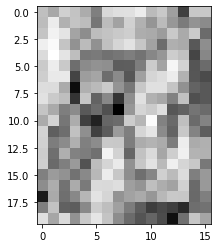

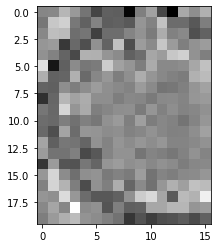

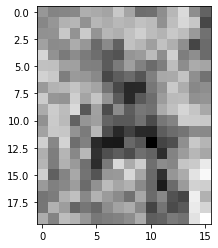

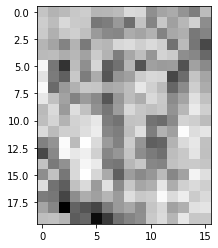

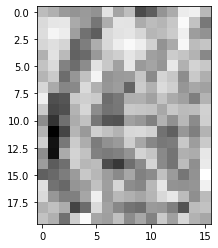

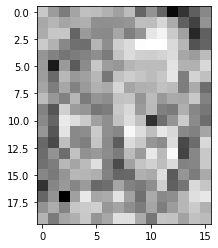

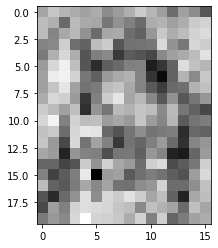

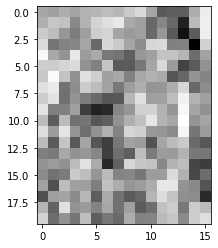

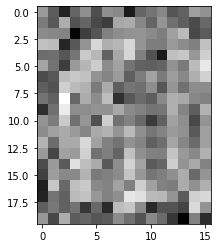

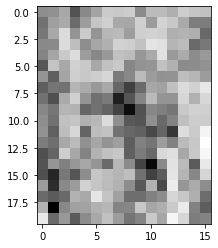

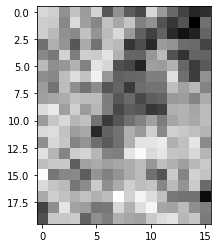

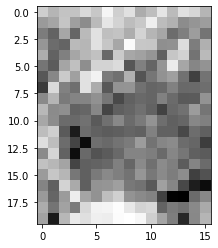

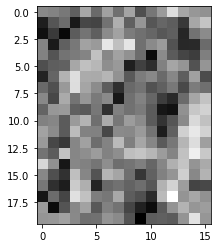

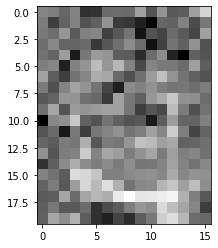

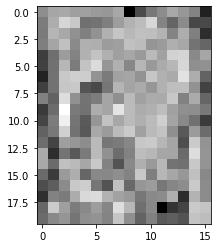

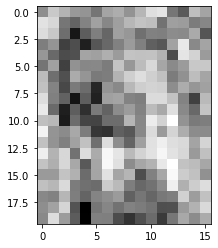

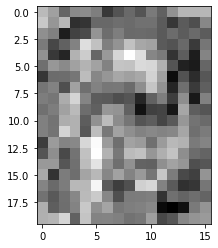

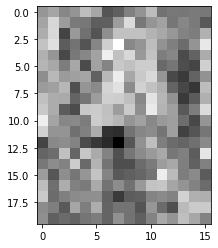

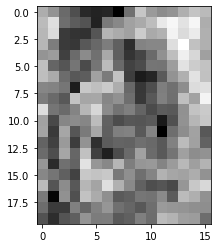

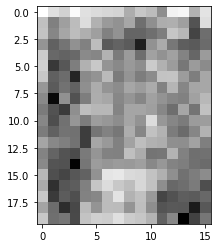

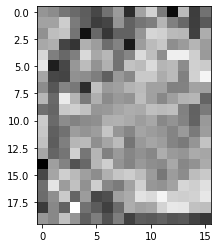

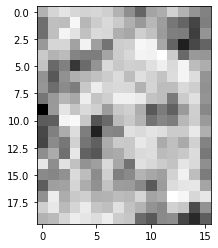

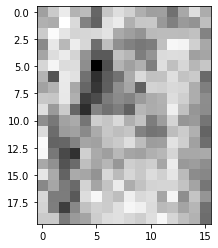

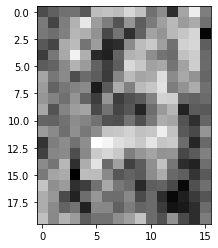

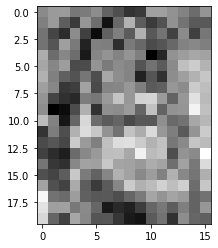

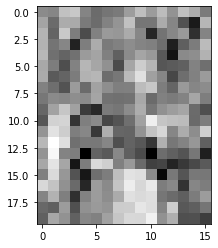

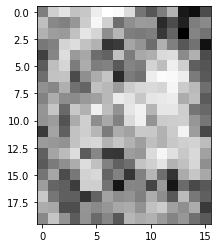

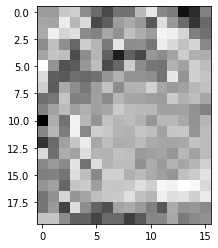

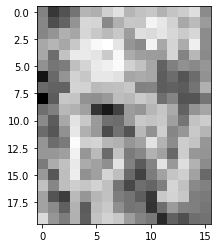

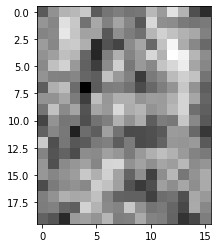

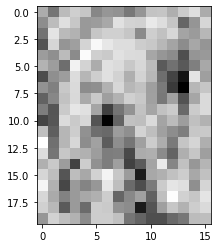

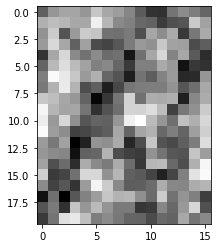

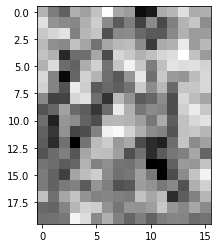

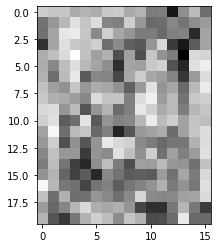

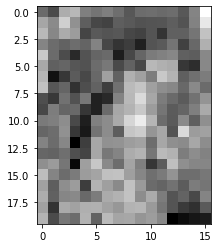

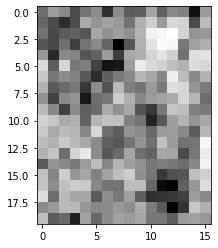

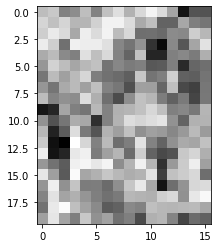

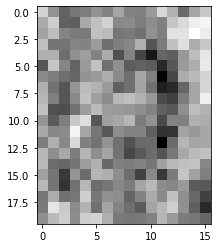

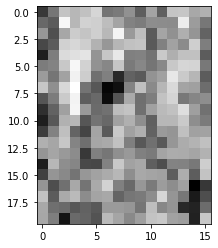

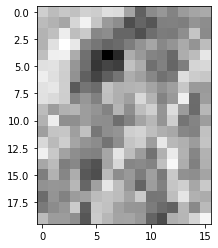

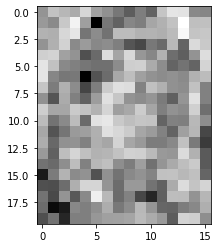

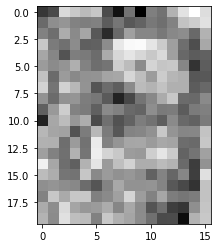

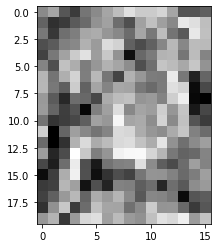

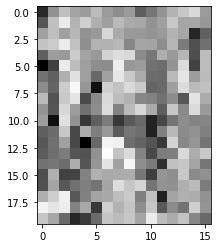

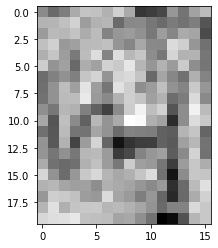

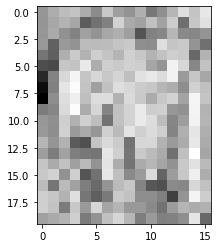

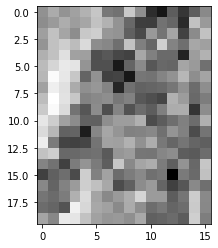

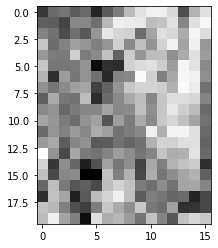

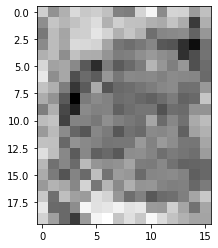

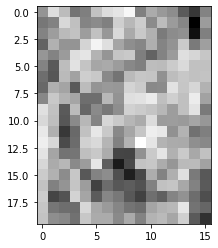

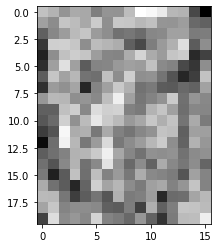

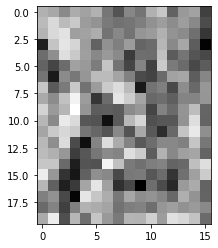

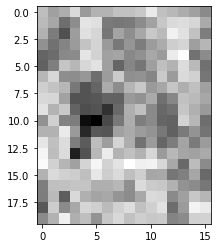

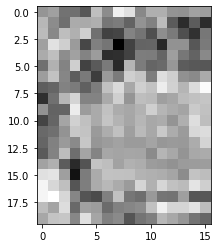

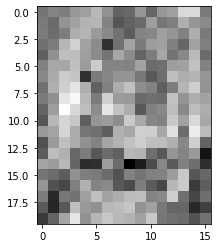

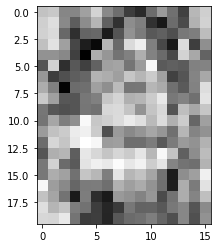

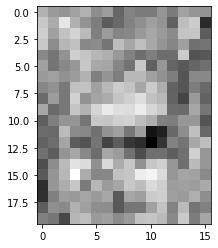

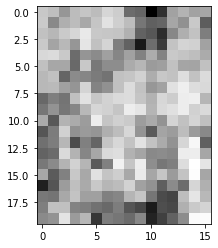

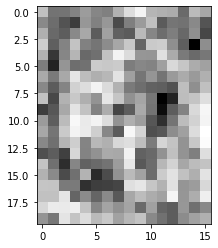

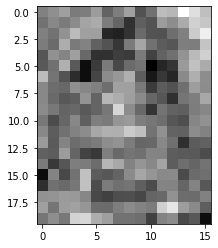

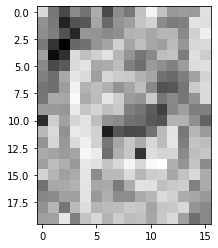

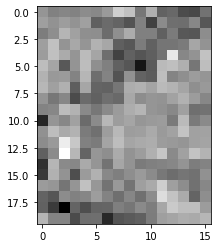

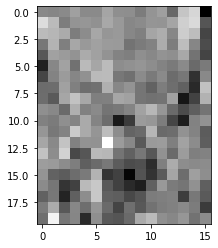

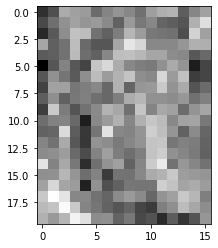

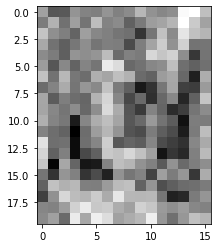

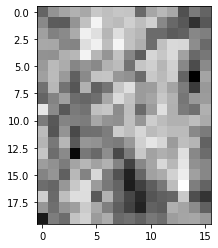

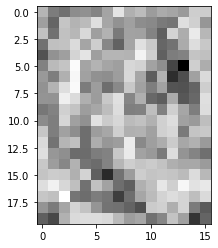

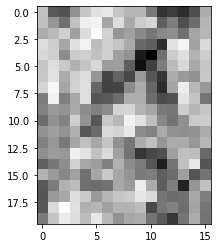

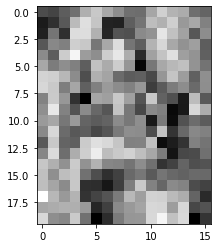

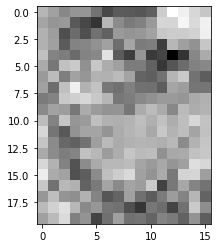

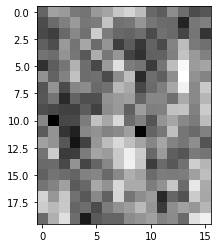

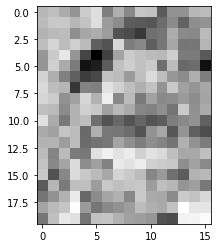

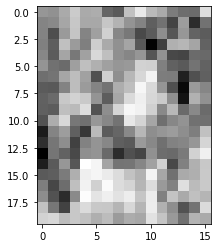

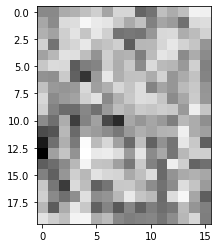

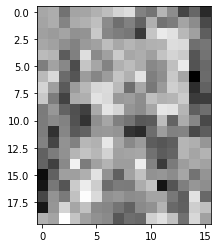

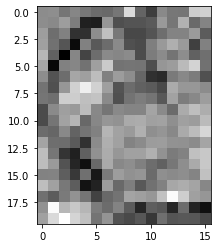

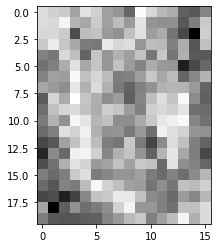

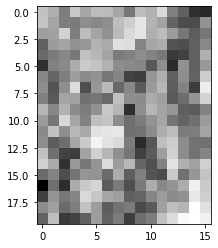

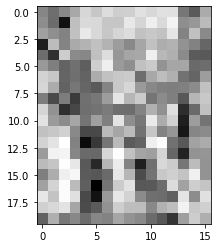

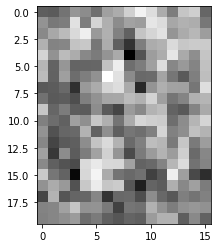

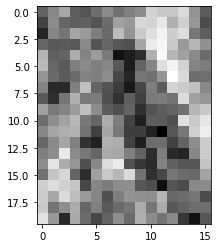

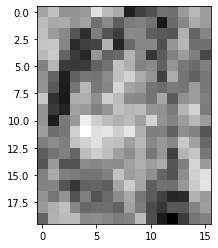

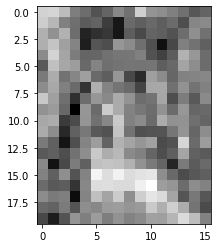

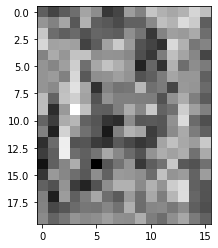

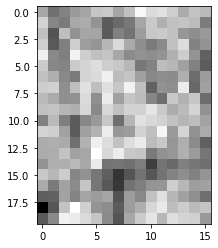

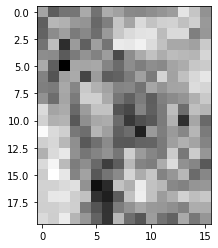

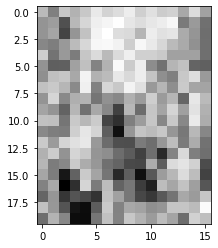

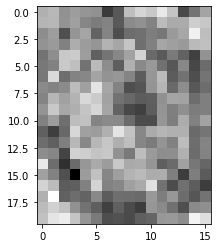

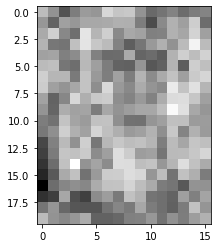

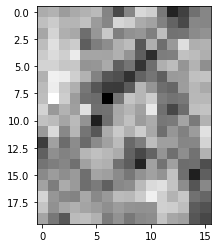

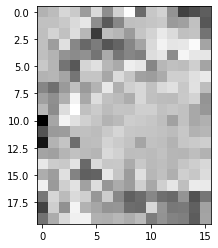

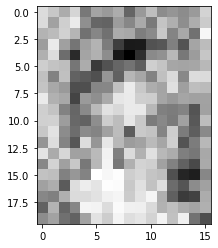

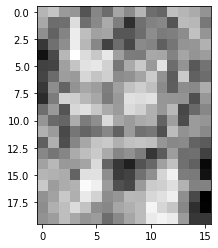

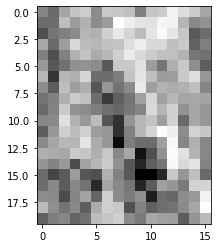

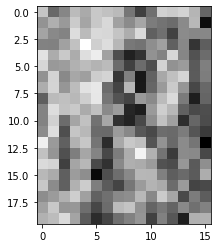

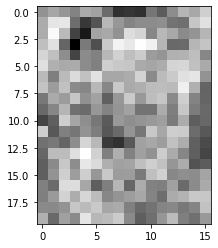

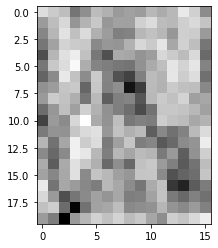

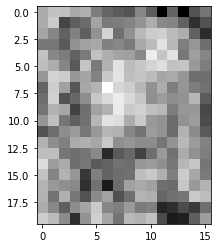

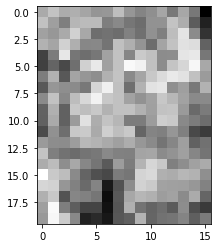

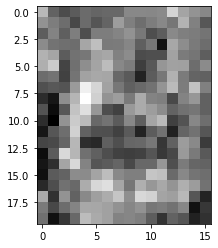

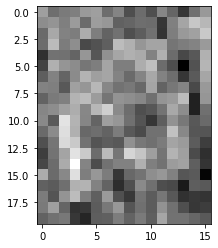

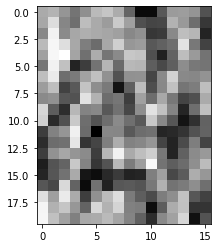

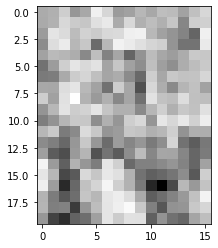

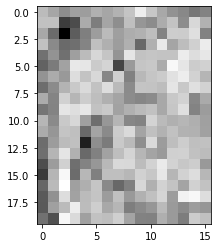

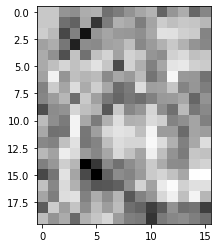

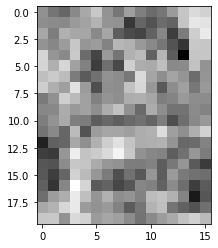

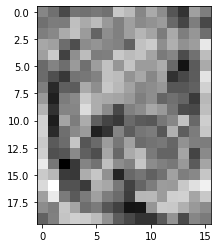

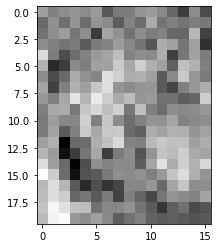

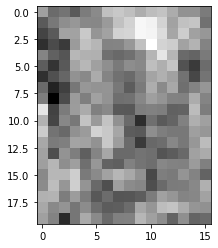

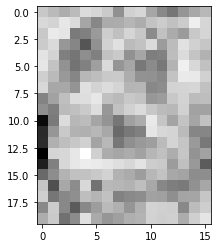

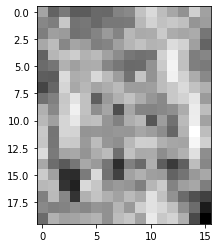

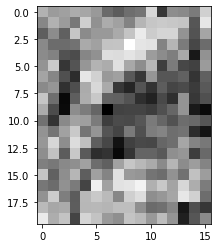

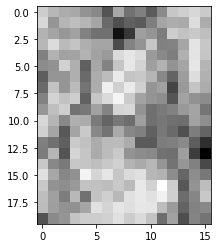

In [10]:
for idx in range(my_rbm.W.shape[1]):
  weights = my_rbm.W[:,idx]
  filter = weights.reshape(20, 16)
  plt.imshow(filter, cmap='Greys')
  plt.show()

# MNIST

In [31]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()
print("Original dimensions train_X: {}".format(train_X.shape))
print("Original dimensions test_X: {}\n".format(test_X.shape))
print("Original dimensions train_y: {}".format(train_y.shape))
print("Original dimensions train_y: {}".format(test_y.shape))


N_train = train_X.shape[0]
N_test = test_X.shape[0]
size = train_X.shape[1]*train_X.shape[2]

train_X = train_X.reshape(N_train, size)
test_X = test_X.reshape(N_test, size)
print("Flattened dimensions train_X: {}".format(train_X.shape))
print("Flattened dimensions test_X: {}\n".format(test_X.shape))

thresh = 50
X = np.vstack((train_X, test_X))
X = (X>thresh).astype(int) 
y = np.hstack((train_y, test_y))
print("Full flattened dataset dimensions: {}".format(X.shape))
print("Full label set dimensions: {}".format(y.shape))

Original dimensions train_X: (60000, 28, 28)
Original dimensions test_X: (10000, 28, 28)

Original dimensions train_y: (60000,)
Original dimensions train_y: (10000,)
Flattened dimensions train_X: (60000, 784)
Flattened dimensions test_X: (10000, 784)

Full flattened dataset dimensions: (70000, 784)
Full label set dimensions: (70000,)


In [32]:
def select_digits(X, y, digits):
    mask = np.zeros(y.shape)
    for label in digits:
        mask = np.logical_or(mask, y == label)
    return X[mask], y[mask]

0 samples with label 0
0 samples with label 1
0 samples with label 2
7141 samples with label 3
0 samples with label 4
0 samples with label 5
0 samples with label 6
0 samples with label 7
6825 samples with label 8
0 samples with label 9


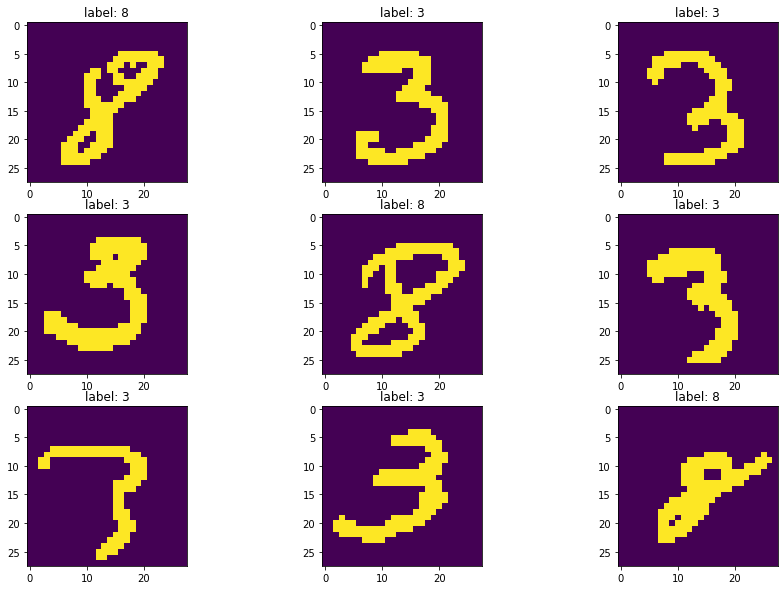

In [36]:
N_train = 70000
X_selected, y_selected = select_digits(X, y, [8,3])
X_train_rbm = X_selected[:N_train]
y_train_rbm = y_selected[:N_train]

for digit in range(10):
    print('{} samples with label {}'.format(sum(y_train_rbm == digit), digit))
n, _ = X_train_rbm.shape
nrow = 3
ncol = nrow

fig, axs = plt.subplots(nrow, ncol, figsize=(15,10))
for i in range(nrow*ncol):
    ax = axs[i//ncol,i%ncol]
    rand_idx = np.random.randint(n)
    rand_sample = X_train_rbm[rand_idx]
    rand_sample = rand_sample.reshape(28,28)
    ax.imshow(rand_sample)
    ax.set_title('label: {}'.format(y_train_rbm[rand_idx]))
    
fig.show()


##### Epoch: 0/100 #####
>>> samples 12289/13966 [88%]

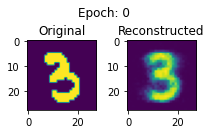


>>> MSE: 0.06148147453591588

##### Epoch: 1/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.04998640113837603

##### Epoch: 2/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.04718726959965471

##### Epoch: 3/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.043305372203560816

##### Epoch: 4/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.04278115280318099

##### Epoch: 5/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.03907481421213755

##### Epoch: 6/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.03870258880280876

##### Epoch: 7/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.035871562998552584

##### Epoch: 8/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.03532034481200481

##### Epoch: 9/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.03328294308811897

##### Epoch: 10/100 #####
>>> samples 12289/13966 [88%]

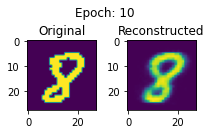


>>> MSE: 0.032821308571705884

##### Epoch: 11/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.03150067915714228

##### Epoch: 12/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.031150399918910394

##### Epoch: 13/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.030243092152633703

##### Epoch: 14/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.029577459306633583

##### Epoch: 15/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.029111926140333623

##### Epoch: 16/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.028496286950304164

##### Epoch: 17/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02794913675034843

##### Epoch: 18/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.027564314936409245

##### Epoch: 19/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02713295844364354

##### Epoch: 20/100 #####
>>> samples 12289/13966 [88%]

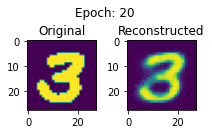


>>> MSE: 0.02689032005014267

##### Epoch: 21/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02644546748915212

##### Epoch: 22/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02607564661351994

##### Epoch: 23/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.025745391856305123

##### Epoch: 24/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.025421870401938468

##### Epoch: 25/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.025197149474887267

##### Epoch: 26/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.024893942359981026

##### Epoch: 27/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02459635027654768

##### Epoch: 28/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.024331644920584764

##### Epoch: 29/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02410521386439755

##### Epoch: 30/100 #####
>>> samples 12289/13966 [88%]

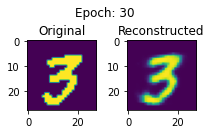


>>> MSE: 0.023881192625827777

##### Epoch: 31/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02366397926662368

##### Epoch: 32/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.023446725555262286

##### Epoch: 33/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.023222627692737644

##### Epoch: 34/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02303459587895844

##### Epoch: 35/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.022872982495045123

##### Epoch: 36/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.022690663719509434

##### Epoch: 37/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.022529633337345024

##### Epoch: 38/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.022370136781491818

##### Epoch: 39/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02218708767195012

##### Epoch: 40/100 #####
>>> samples 12289/13966 [88%]

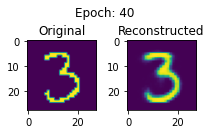


>>> MSE: 0.02202314581425361

##### Epoch: 41/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.021906664538268186

##### Epoch: 42/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.0217687801694482

##### Epoch: 43/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.021622016624116225

##### Epoch: 44/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.021415184752399848

##### Epoch: 45/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02129120689217692

##### Epoch: 46/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02118493254463021

##### Epoch: 47/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.021069889364065567

##### Epoch: 48/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.020965344337688496

##### Epoch: 49/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.020809799463795065

##### Epoch: 50/100 #####
>>> samples 12289/13966 [88%]

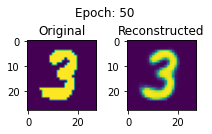


>>> MSE: 0.02071894843165489

##### Epoch: 51/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.020594132066325137

##### Epoch: 52/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.020438504014430512

##### Epoch: 53/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.020379667681424213

##### Epoch: 54/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.020242610866931653

##### Epoch: 55/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.020131784719945298

##### Epoch: 56/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02007588128435748

##### Epoch: 57/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.019953922806078307

##### Epoch: 58/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01983087847735472

##### Epoch: 59/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01975748987925119

##### Epoch: 60/100 #####
>>> samples 12289/13966 [88%]

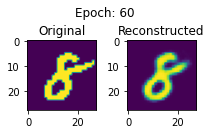


>>> MSE: 0.019660461819889844

##### Epoch: 61/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.019518903605676957

##### Epoch: 62/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.019456402268080746

##### Epoch: 63/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01936727473554128

##### Epoch: 64/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.019279700228350717

##### Epoch: 65/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01922156703716847

##### Epoch: 66/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.019107012313108192

##### Epoch: 67/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.019045093540902377

##### Epoch: 68/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.018937904545687275

##### Epoch: 69/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.018873203319701267

##### Epoch: 70/100 #####
>>> samples 12289/13966 [88%]

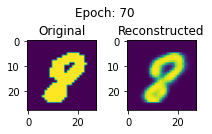


>>> MSE: 0.018772418450932818

##### Epoch: 71/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01870550062454468

##### Epoch: 72/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01862087389837339

##### Epoch: 73/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.018553730709160964

##### Epoch: 74/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.018448176923020972

##### Epoch: 75/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01840461058497729

##### Epoch: 76/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.018357768650854325

##### Epoch: 77/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.018273300797337237

##### Epoch: 78/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.018168779300746733

##### Epoch: 79/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01811028022826876

##### Epoch: 80/100 #####
>>> samples 12289/13966 [88%]

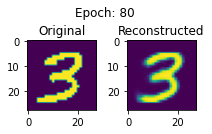


>>> MSE: 0.01803022547537668

##### Epoch: 81/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01795730808564013

##### Epoch: 82/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017918438934046814

##### Epoch: 83/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017860961043684693

##### Epoch: 84/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017753878754510687

##### Epoch: 85/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01772555882145998

##### Epoch: 86/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017693682118100424

##### Epoch: 87/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017587435918438695

##### Epoch: 88/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01757449900122681

##### Epoch: 89/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017468458610372835

##### Epoch: 90/100 #####
>>> samples 12289/13966 [88%]

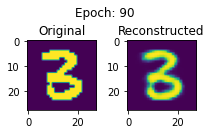


>>> MSE: 0.017426064802448016

##### Epoch: 91/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017358388388479536

##### Epoch: 92/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017307950455100668

##### Epoch: 93/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017250137456393387

##### Epoch: 94/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017184583882135344

##### Epoch: 95/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01713527476383598

##### Epoch: 96/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017072359509030015

##### Epoch: 97/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017034904995889083

##### Epoch: 98/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.016954630708583357

##### Epoch: 99/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01691128941442036


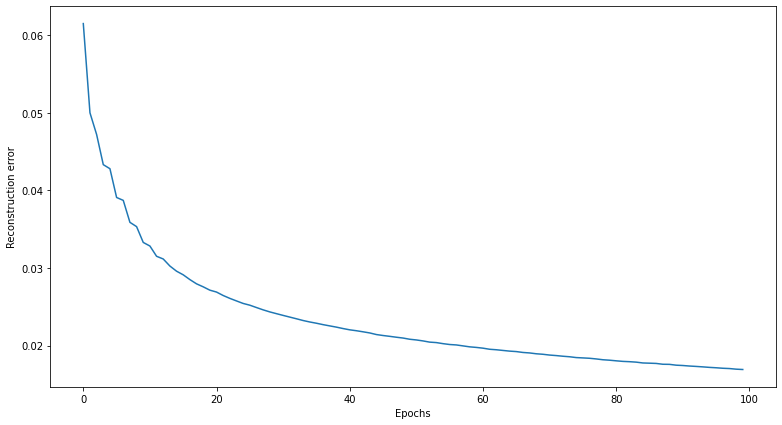

In [37]:
_, p = X_train_rbm.shape

my_rbm = RBM(p, q=512)
err_history = my_rbm.train(X_train_rbm, nb_epoch=100, batch_size=2048, lr=1e-1, 
                           height=28, width=28, epoch_per_plot=10)

plt.figure(figsize=(13,7))
plt.plot(np.arange(0, len(err_history)), np.sqrt(err_history))
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

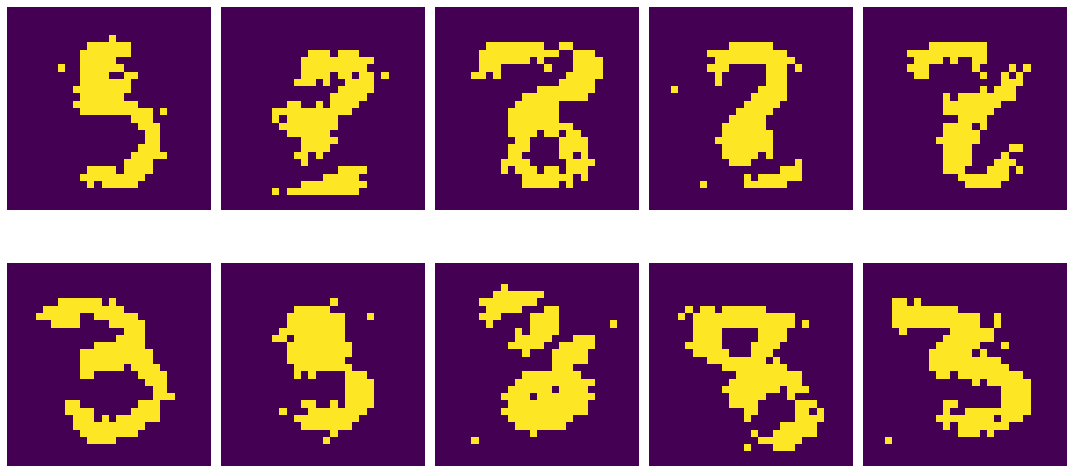

In [38]:
my_rbm.generate(nb_iter=1000, thresh=.2, height=28, width=28)


##### Epoch: 0/100 #####
>>> samples 12289/14017 [88%]

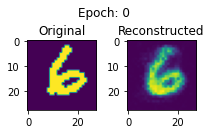


>>> MSE: 0.04913121004194385

##### Epoch: 1/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.04457163397165689

##### Epoch: 2/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.038488037737773706

##### Epoch: 3/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.03537571920457012

##### Epoch: 4/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.03241880401836568

##### Epoch: 5/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.031144384123689046

##### Epoch: 6/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.02906870890313716

##### Epoch: 7/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.027849890687295854

##### Epoch: 8/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.02687121900099282

##### Epoch: 9/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.02585967894353607

##### Epoch: 10/100 #####
>>> samples 12289/14017 [88%]

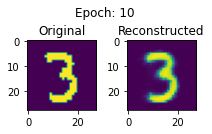


>>> MSE: 0.025061862727446715

##### Epoch: 11/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.024162303555567595

##### Epoch: 12/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.023578541630217525

##### Epoch: 13/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.022865219937173872

##### Epoch: 14/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.02246348603472853

##### Epoch: 15/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.02187374937677993

##### Epoch: 16/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.021480557926249148

##### Epoch: 17/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.0209323973728293

##### Epoch: 18/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.020598662446058097

##### Epoch: 19/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.02020050411604505

##### Epoch: 20/100 #####
>>> samples 12289/14017 [88%]

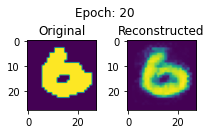


>>> MSE: 0.01988262845006171

##### Epoch: 21/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01954434171548477

##### Epoch: 22/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.019251782881278424

##### Epoch: 23/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.019034691819078665

##### Epoch: 24/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01875647587362797

##### Epoch: 25/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.018499012652299432

##### Epoch: 26/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.018255191983332357

##### Epoch: 27/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.017990874464075393

##### Epoch: 28/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01774046693463474

##### Epoch: 29/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.0176269251489725

##### Epoch: 30/100 #####
>>> samples 12289/14017 [88%]

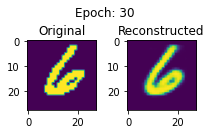


>>> MSE: 0.01733689096490047

##### Epoch: 31/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.017205062500085033

##### Epoch: 32/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01700503893344727

##### Epoch: 33/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.016807308597579413

##### Epoch: 34/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01667163604107336

##### Epoch: 35/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.016483811128461697

##### Epoch: 36/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.016332736268115752

##### Epoch: 37/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01618121305986022

##### Epoch: 38/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.016001367215987838

##### Epoch: 39/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.015853926407906865

##### Epoch: 40/100 #####
>>> samples 12289/14017 [88%]

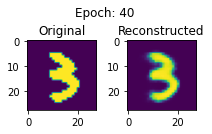


>>> MSE: 0.01571983001291621

##### Epoch: 41/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.015606869799301325

##### Epoch: 42/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.015489039935667729

##### Epoch: 43/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.015332985913497785

##### Epoch: 44/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.015222851600400619

##### Epoch: 45/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.015121336985811626

##### Epoch: 46/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01496360311240544

##### Epoch: 47/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.014855717319676153

##### Epoch: 48/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.014779563640192278

##### Epoch: 49/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01464191170987214

##### Epoch: 50/100 #####
>>> samples 12289/14017 [88%]

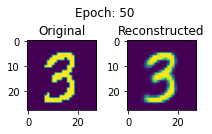


>>> MSE: 0.014562915476460271

##### Epoch: 51/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.014470310197465433

##### Epoch: 52/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.0143600516611703

##### Epoch: 53/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.014256024931015819

##### Epoch: 54/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.014168427057697873

##### Epoch: 55/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.014063748551706159

##### Epoch: 56/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.013968912068831468

##### Epoch: 57/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01388567583438475

##### Epoch: 58/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01380049107263508

##### Epoch: 59/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.013727779096840993

##### Epoch: 60/100 #####
>>> samples 12289/14017 [88%]

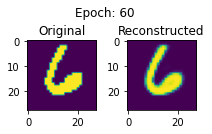


>>> MSE: 0.01364461535679666

##### Epoch: 61/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.013598030571945459

##### Epoch: 62/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.013486594119728006

##### Epoch: 63/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.013424468222562765

##### Epoch: 64/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.013339586377863253

##### Epoch: 65/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.013237644495321213

##### Epoch: 66/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.0132012417296058

##### Epoch: 67/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01315256377275003

##### Epoch: 68/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.013049972435007502

##### Epoch: 69/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.012984124908602835

##### Epoch: 70/100 #####
>>> samples 12289/14017 [88%]

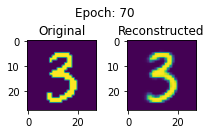


>>> MSE: 0.012923062057748203

##### Epoch: 71/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.012885038175187382

##### Epoch: 72/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.012802177462254035

##### Epoch: 73/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.012700324442599132

##### Epoch: 74/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.012657040890623293

##### Epoch: 75/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.012601699473259377

##### Epoch: 76/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.012549404808413843

##### Epoch: 77/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.012498384413051483

##### Epoch: 78/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.012451804655479097

##### Epoch: 79/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.012378468168843734

##### Epoch: 80/100 #####
>>> samples 12289/14017 [88%]

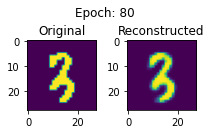


>>> MSE: 0.01230957753385278

##### Epoch: 81/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.012268674522467236

##### Epoch: 82/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.012203717904947712

##### Epoch: 83/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.012164847713085427

##### Epoch: 84/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01210429970735704

##### Epoch: 85/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.0120532937722273

##### Epoch: 86/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.011991181973084426

##### Epoch: 87/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.011940338692081937

##### Epoch: 88/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01192050371027442

##### Epoch: 89/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01186961410247565

##### Epoch: 90/100 #####
>>> samples 12289/14017 [88%]

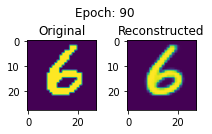


>>> MSE: 0.01179403184966085

##### Epoch: 91/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.011792225211231142

##### Epoch: 92/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.011714973781516865

##### Epoch: 93/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01164369885081588

##### Epoch: 94/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01164059876584424

##### Epoch: 95/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.011576367284784625

##### Epoch: 96/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.011519802518931841

##### Epoch: 97/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.011482465426263239

##### Epoch: 98/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.011446379804167102

##### Epoch: 99/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.011420894950497845


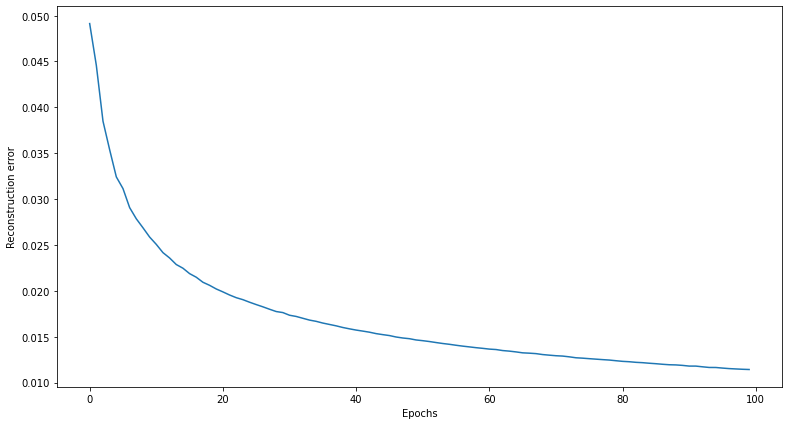

In [36]:
N_train = 70000
X_selected, y_selected = select_digits(X, y, [3,6])
X_train_rbm = X_selected[:N_train]
y_train_rbm = y_selected[:N_train]

_, p = X_train_rbm.shape

my_rbm2 = RBM(p, q=512)
err_history = my_rbm2.train(X_train_rbm, nb_epoch=100, batch_size=2048, lr=1e-1, 
                           height=28, width=28, epoch_per_plot=10)

plt.figure(figsize=(13,7))
plt.plot(np.arange(0, len(err_history)), np.sqrt(err_history))
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

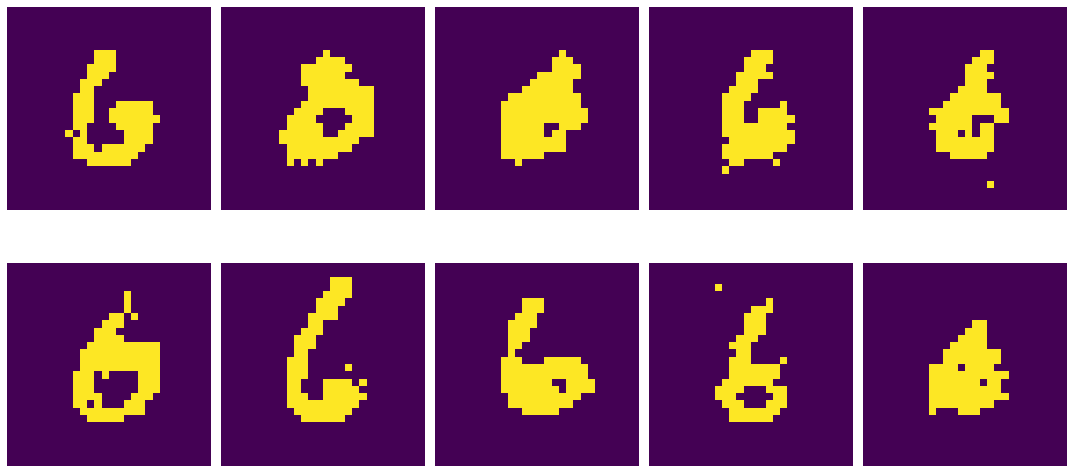

In [41]:
my_rbm2.generate(nb_iter=1000, thresh=.5, height=28, width=28)